# MULTI-TASK DEEP REINFORCEMENT LEARNING

This is the python notebook file which houses all code related to the Multi-Task Deep Reinforcement Learning project in the 2022 Tripods/StemForAll REU program run through the University of Rochester. We have built different grid games and different agents to play these grid games.

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import time
from random import sample
import numpy.random as random
import matplotlib.pyplot as plt

# GRIDWORLD

This class allows us to define a grid game and its basic characteristics such as the size of the board, where the agent starts and currently is during an episode, and what its reward matrix and possible moves are

In [2]:
class GridWorld:
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        self.board_dims = board_dims
        self.height, self.width = board_dims
        self.start_state = start_state
        self.agent_pos = start_state
        self.terminal_state = terminal_state
        self.reward_matrix = reward_matrix
        self.moves = [(-1,0),(0,-1),(1,0),(0,1)] #up,left,down,right
        
    def get_moves(self, point):
        """
        point - the point our agent is in
        This function obtains the points of possible moves you can potentially make from the point provided,
        return being the ending position of the move

        """
        return [tuple(np.array(point)+np.array(x)) for x in self.moves]

    def point_to_index(self, point):
        """
        point - the point we want to convert to index (for list of lists e.g.)
        This function obtains the index when you iterate across each column over each row of our game board
        """
        return point[0]*self.width + point[1]

    def index_to_point(self, index):
        """
        index - the index we want to convert to game square point
        This function obtains the index when you iterate across each column over each row of our game board
        """
        #(divisions, remainder)
        return (index // self.width, index % self.width)

    def get_reward(self,point):
        """
        point - a point in our grid
        This function returns the reward for our agent going to the state represented by point
        """
        return self.reward_matrix[point]
    
    def illegal_move(self,point):
        """
        point - a point that may or may not be in our grid
        This function returns true if the move we make takes us off the board and false if the move is legal
        """
        return True if ((point[0] < 0 or point[0] == self.height) or (point[1] < 0 or point[1] == self.width)) else False
        
    def print_board(self):
        print(self.reward_matrix)

# Individual Game Implementations

Here we define each game and have it inherit attributes from GridWorld object

## Targeting Game

The targeting game tasks consists of the agent starting in a different square from the "target" square. The goal of the game is to have the agent reach the target square in as few moves as possible

In [3]:
class Targeting_Game(GridWorld):
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        GridWorld.__init__(self,board_dims, start_state, terminal_state, reward_matrix)
        
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                elif(i == self.terminal_state[0] and j == self.terminal_state[1]):
                    color = "red"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        display(image)

    def update_state(self,new_pos, if_illegal):
      """
      new_pos - a point in the game grid that the agent has moved to
      This function updates the agent position for the GameGrid class variable.
      """
      if not if_illegal:
          self.agent_pos = new_pos

    def is_episode_terminal(self):
        """
        This function returns a boolean based on if the Game's current episode is finished.
        """
        return True if self.agent_pos == self.terminal_state else False

    def refresh_game(self):
        """
        This function refreshes the important features of the game that might have changed within an episode
        """
        self.agent_pos = self.start_state

## Collection Game

The collection game tasks consists of the agent starting in a different square from a set of prize squares. The goal of the game is to have the agent collect each prize in the prize squares in as few moves as possible (prizes being removed upon collection)

In [5]:
class Collection_Game(GridWorld):
    def __init__(self, board_dims, start_state, prize_states, reward_matrix, prize_value=0):
        GridWorld.__init__(self,board_dims, start_state, None, reward_matrix)
        self.prize_states = prize_states
        self.remaining_prize_states = list(prize_states)
        self.prize_value = prize_value
        for prize_state in prize_states:
            self.reward_matrix[prize_state] = prize_value
    
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        #Draw Prizes
        if len(self.remaining_prize_states) > 1:
            for x in self.remaining_prize_states:
                draw.rectangle(((x[1]*w + w/4, x[0]*h + h/4), (3*w/4+x[1]*w, 3*h/4+x[0]*h)), outline = "black", fill = "yellow")
        elif len(self.remaining_prize_states) == 1:
            remaining_prize = self.remaining_prize_states[0]
            draw.rectangle(((remaining_prize[1]*w + w/4, remaining_prize[0]*h + h/4), (3*w/4+remaining_prize[1]*w, 3*h/4+remaining_prize[0]*h)), outline = "black", fill = "yellow")
      
        display(image)

    def update_state(self,new_pos, if_illegal):
        """
        new_pos - a point in the game grid that the agent has moved to
        This function updates the agent position for the GameGrid class variable.
        """
        if not if_illegal:
            self.agent_pos = new_pos

        if self.agent_pos in self.remaining_prize_states:
            self.remove_prize(self.agent_pos)

    def remove_prize(self, prize_point):
        """
        prize_point - a point in the game grid that contained a prize
        This function removes the prize at the prize_point supplied from the remaining prizes. This function also
            updates the reward matrix accordingly.
        """
        #remove prize from remaining prizes
        self.remaining_prize_states.remove(prize_point)
        #adjust reward matrix to account for no prize at this prize_point for the rest of the episode
        self.reward_matrix[prize_point] = self.reward_matrix[self.start_state]
        #if there remains one prize, set that to be the terminal state for the episode
        if len(self.remaining_prize_states) == 1:
            self.terminal_state = self.remaining_prize_states[0]
        
    def is_episode_terminal(self):
        return True if len(self.remaining_prize_states) == 0 else False

    def refresh_game(self):
        """
        This function refreshes the game's agent position, the remaining prizes, the reward matrix, and terminal 
            state. This is used between each episode
        """
        self.agent_pos = self.start_state
        self.remaining_prize_states = list(self.prize_states)
        self.terminal_state = None
        
        for prize_state in self.prize_states:
            self.reward_matrix[prize_state] = self.prize_value

## FindMax_Game



In [6]:
from PIL import ImageFont

class FindMax_Game(GridWorld):
    
    def __init__(self, board_dims, start_state, reward_matrix):
        # the terminal state is where the max value locates
        self.terminal_state = np.unravel_index(np.argmax(reward_matrix, axis=None), board_dims)
        GridWorld.__init__(self, board_dims, start_state, self.terminal_state, reward_matrix)
        # self.max_value = reward_matrix[self.terminal_state]
        self.reward_matrix = reward_matrix
        # initial sum of rewards is the reward value at the start state
        self.sum = reward_matrix[start_state] 
        # the number of steps
        self.n_steps = 0
        # the step limit is the Manhattan distance between the start state and the terminal state
        self.step_limit = sum(abs(np.array(self.terminal_state)-np.array(start_state)))
        

        

    def draw(self):

        image = Image.new("RGBA", (501, 501), (255, 255, 255, 255)) # white
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = (255, 255, 255, 0) # white, transparent

        # use !fc-list or !fc-list | grep "" to get the path of the font-type on colab
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 40) 
        
        
        #Draw Grid
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = (0, 0, 255, 255)  # blue for the starting point
                if(i == self.terminal_state[0] and j == self.terminal_state[1]):
                    color = (255, 0, 0, 255)  # red for the max
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                text_h = font.getsize(str(self.reward_matrix[(i,j)]))[1]
                text_w = font.getsize(str(self.reward_matrix[(i,j)]))[0]
                draw.text((j*w + w/2 - text_w/2, i*h + h/2 - text_h/2), 
                          str(self.reward_matrix[(i,j)]), font=font, fill=(0, 0, 0, 255))
                color = (255, 255, 255, 0)

        #Draw Agent
        agent_layer = Image.new('RGBA', (501, 501), (255, 255, 255, 0))
        draw2 = ImageDraw.Draw(agent_layer)
        draw2.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), 
                     fill=(255, 0, 255, 128)) 
      
        out = Image.alpha_composite(image, agent_layer)
        display(out)

      
    def update_state(self,new_pos, if_illegal):
      """
      new_pos - a point in the game grid that the agent has moved to
      a function to update the position of agent, number of steps, and sum of rewards,
      """
      if not if_illegal:
          self.agent_pos = new_pos
      self.n_steps += 1 # once the agent moves, the number of steps taken (var n_step) +1
      # self.remaining_prize_states -= 1
      self.sum += reward_matrix[self.agent_pos] 


    # def update_sum(self, new_pos):
    #   """
    #   new_pos - a point in the game grid that the agent has moved to
    #   This function updates the sum of rewards
    #   """
    #   self.sum += reward_matrix[new_pos] 


    def is_episode_terminal(self):
      # return True if self.n_steps == self.step_limit else False
      return True if self.agent_pos == self.terminal_state else False


    def refresh_game(self):
      self.agent_pos = self.start_state
      self.sum = self.reward_matrix[self.start_state] 
      self.n_steps = 0
      # self.remaining_prize_states = self.step_limit

## MaxPath_Game

In [7]:
from PIL import ImageFont

class MaxPath_Game(GridWorld):
    
    def __init__(self, board_dims, start_state, reward_matrix):
        self.max_state = np.unravel_index(np.argmax(reward_matrix, axis=None), board_dims)
        # no fixed terminal state, this game will terminate when the step limit is reached 
        GridWorld.__init__(self, board_dims, start_state, None, reward_matrix) 
        # self.max_value = reward_matrix[self.max_state]
        self.reward_matrix = reward_matrix
        # initial sum of rewards is the reward value at the start state
        # self.sum = reward_matrix[start_state] 
        self.sum = 0 # initial sum of rewards is 0
        # the number of steps
        self.n_steps = 0
        # the step limit is (board_width - 1)+(board_height - 1)
        self.step_limit = (self.width - 1)+(self.height - 1)


    def draw(self):

        image = Image.new("RGBA", (501, 501), (255, 255, 255, 255)) # white
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = (255, 255, 255, 0) # white, transparent

        # use !fc-list or !fc-list | grep "" to get the path of the font-type on colab
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 40) 
        
        
        #Draw Grid 
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = (0, 0, 255, 255)  # blue for the starting point
                if(i == self.max_state[0] and j == self.max_state[1]):
                    color = (255, 0, 0, 255)  # red for the max
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                text_h = font.getsize(str(self.reward_matrix[(i,j)]))[1]
                text_w = font.getsize(str(self.reward_matrix[(i,j)]))[0]
                draw.text((j*w + w/2 - text_w/2, i*h + h/2 - text_h/2), 
                          str(self.reward_matrix[(i,j)]), font=font, fill=(0, 0, 0, 255))
                color = (255, 255, 255, 0)

        #Draw Agent
        agent_layer = Image.new('RGBA', (501, 501), (255, 255, 255, 0))
        draw2 = ImageDraw.Draw(agent_layer)
        draw2.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), 
                     fill=(255, 0, 255, 128)) 
      
        out = Image.alpha_composite(image, agent_layer)
        display(out)

      
    def update_state(self, new_pos, if_illegal):
      """
      new_pos - a point in the game grid that the agent has moved to
      a function to update the position of agent, number of steps, and sum of rewards,
      """
      if not if_illegal:
          self.agent_pos = new_pos
      
      self.n_steps += 1 # once the agent moves, the number of steps taken (var n_step) +1
      # self.remaining_prize_states -= 1
      self.sum += reward_matrix[self.agent_pos] 


    # def update_sum(self, new_pos):
    #   """
    #   new_pos - a point in the game grid that the agent has moved to
    #   This function updates the sum of rewards
    #   """
    #   self.sum += reward_matrix[new_pos] 


    def is_episode_terminal(self):
      return True if self.n_steps >= self.step_limit else False


    def refresh_game(self):
      self.agent_pos = self.start_state
      self.sum = self.reward_matrix[self.start_state] 
      self.n_steps = 0
      # self.remaining_prize_states = self.step_limit

[[7 8 9]
 [4 5 6]
 [1 2 3]]
9
(0, 2)


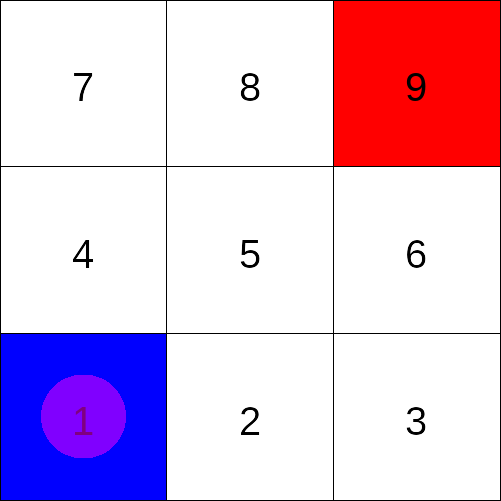

In [9]:
reward_matrix = np.asarray([[7,8,9], [4,5,6], [1,2,3]])
print(reward_matrix)
print(np.max(reward_matrix))
print(np.unravel_index(np.argmax(reward_matrix, axis=None), reward_matrix.shape))
max_game = FindMax_Game((3,3), (2,0), reward_matrix)
max_game.draw()


# Players and Agents

Here we define different agents and allow them to play our games that we define above in the previous section

For Tabular solving agents we've made Monte Carlo Agents, Temporal Difference Agents, and Planning Agents. Monte Carlo and Temporal Difference Agents learn strictly from real experience (playing the game) and the planning agent learns from both real experience and simulated experience (build a model of the game's reward matrix

In [10]:
class QTable:
    """
    This class implements the qtable object used for all tabular agent qtable classes
      This class includes parameters that are used in every tabular agent
    """
    def __init__(self, Game, alpha, epsilon, discount, alpha_decay_rate = 0.6, epsilon_decay_rate=1.0):
        self.Game = Game
        self.qtable = np.zeros([Game.height*Game.width, len(self.Game.moves)])
        self.alpha = alpha
        self.discount = discount
        self.epsilon = epsilon
        self.alpha_decay_rate = alpha_decay_rate
        self.epsilon_decay_rate = epsilon_decay_rate

    def alpha_decay(self):
        self.alpha = self.alpha*self.alpha_decay_rate
        
    def epsilon_decay(self):
        self.epsilon = self.epsilon*self.epsilon_decay_rate
        
    def get_return(self, state, action):
        """
        state - some integer index corresponding to a tuple point in the grid game
        action - some integer index corresponding to a possible action taken in the grid game
        This function returns the expected return from the qtable for a specific action made in a specific state
        """
        return self.qtable[state, action]
      

## Monte Carlo

Monte Carlo agents accumulate state,action,reward tuples for an entire episode before updating their action-value functions. We consider two cases of Monte Carlo RL agents: on-policy and off-policy. On-policy agents have one policy that determines the agent's behavior in the environment and converges to an optimal policy over time. Off-policy agents have two policies, one that the determines the agent's behavior in the environment (behavior policy) and one that corresponds to the agents optimal policy after sufficient experience (target policy)

### MCAgent

In [18]:
class MCAgent:
    """
    This class implements a Monte Carlo agent that can play grid games
    """
    def __init__(self, Game, model):
        self.Game = Game
        self.model = model
        self.target_policy = None
        
    def get_target_policy(self):
        """
        This function obtains the target policy derived (greedily) from the qtable
        """
        self.target_policy = self.model.target_policy

    def print_models(self):
        self.model.print_models()

    def play_episode(self):
        """
        This function plays an episode of the grid game and keeps track of the 
        states visited, actions made, and rewards obtained during the episode. 
        Once completion of the episode, we update our qtable model with the episode story
        """
        t = 0
        episode_reward = 0
        episode_story = []
        #while agent is not in a terminal state
        while not self.Game.is_episode_terminal():
            t += 1
            #Take action A, get reward R, step into s'
            
            current_state = self.Game.agent_pos
            #get possible moves going up, left, down, and right
            new_action = self.model.get_action(self.Game.agent_pos)
            new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))
            
            
            #if move is illegal (going off the board), set reward to very bad
            if self.Game.illegal_move(new_state):
                reward = -100
                self.Game.update_state(tuple(new_state), True)
            else:
            #else the selected move is legal and we should get reward r for agent going to state s'
                reward = self.Game.get_reward(new_state)
                self.Game.update_state(tuple(new_state), False)
            
            #convert to qtable indices
            state = self.Game.point_to_index(current_state)
            action = self.Game.moves.index(new_action)
            
            #add s_t, a_t, r_t+1 to the episode story
            episode_story.append(tuple((state,action,reward)))
            
            episode_reward += reward
        
        self.model.update_model(episode_story)
        self.model.alpha_decay()
        self.model.epsilon_decay()
        return episode_reward
                
    
    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)
            episode_reward = self.play_episode()
            player_scores.append(episode_reward)
            self.Game.refresh_game()
            
            print("Reward for Episode: ",i," -> ",episode_reward)

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

### On-Policy First Visit QTable Model

In [19]:
class MC_OnPolicy_FirstVisit_QTable(QTable):
    """
    This class represents the qtable with on-policy first visit Monte Carlo update rules
    """
    def __init__(self, Game, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        
    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.target_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.target_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,episode_story):
        """
        episode_story - a list of tuples corresponding to rewards obtained from 
          making a specific action from a specific state
        This function updates the policy using on-policy first visit MC methods
        """
        G = 0
        
        #for each state action reward starting from terminal state time step (T) - 1
        for t, (state,action,reward) in enumerate(reversed(episode_story)):
            G = self.discount*G + reward

            if tuple((state,action,reward)) not in episode_story[0:len(episode_story)-t-1]: #first visit condition. if the tuple has not appeard in previous stages of episode, then update its qtable values
                self.qtable[state,action] += self.alpha * (G - self.qtable[state,action])
                
                max_action_idx = np.argmax(self.qtable[state])
                #update e-greedy policy
                for a in range(0,len(self.Game.moves)):
                    #update sub-optimal actions in state to be chosen with explore probability
                    self.target_policy[state][a] = self.epsilon/len(self.Game.moves)
                #update optimal action in state to be chosen with exploit probability + explore probability
                self.target_policy[state][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
            
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        

### Off-Policy QTable Model

Off-policy methods utilize this important idea of importance sampling. When generating experience and rewards from the environment from some behavior policy b(a|s), the expected reward will be slightly different for the behavior policy and the target policy. Thus to correct for this, we mulitply our reward by the ratio of the probability of seeing the episode's state action trajectory occur under each policy.

In [11]:
class MC_OffPolicy_QTable(QTable):
    """
    This class represents the qtable with off-policy Monte Carlo update rules
    """
    def __init__(self, Game, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.behavior_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.cumul_weights = np.zeros_like(self.qtable)
        
    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.target_policy)
        print(self.behavior_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,episode_story):
        """
        episode_story - a list of tuples corresponding to rewards obtained from 
          making a specific action from a specific state
        This function updates the policy using off-policy MC methods and importance sampling
        """
        G = 0
        W = 1
        
        #for each (state action reward) tuple starting from terminal state time step (T) - 1
        for t, (state,action,reward) in enumerate(reversed(episode_story)):
            G = self.discount*G + reward
            self.cumul_weights[state,action] += W
            self.qtable[state,action] += (W / self.cumul_weights[state,action]) * (G - self.qtable[state,action])

            max_action_idx = np.argmax(self.qtable[state])

            #update policy deterministically (greedily) w.r.t the qtable
            for a in range(0,len(self.Game.moves)):
                self.target_policy[state][a] = 0
            self.target_policy[state][max_action_idx] = 1
            
            #update e-greedy policy
            for a in range(0,len(self.Game.moves)):
                #update sub-optimal actions in state to be chosen with explore probability
                self.behavior_policy[state][a] = self.epsilon/len(self.Game.moves)
            #update optimal action in state to be chosen with exploit probability + explore probability
            self.behavior_policy[state][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
            
#             if action != max_action_idx:
#                 break
            
            W = W / self.behavior_policy[state,action]
            
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        

## Temporal Difference

Temporal Difference Agents utilize Monte Carlo and Dynamic Programming ideas. If we want to update are qtable before the episode ends, we utilize temporal difference learning. The idea is to lookahead only a finite number of steps, and only factor the next n-steps into your return estimate for time step t. The popular Q-Learning method is an example of a one-step temporal difference learning method.



### one-step TDAgent

In [14]:
class TDAgent:
    """
    This class implements a one-step temporal difference agent that can play grid games
    """
    def __init__(self, Game, model):
        self.Game = Game
        self.model = model
        self.target_policy = None
        
    def get_target_policy(self):
        """
        This function obtains the target policy derived from the qtable
        """
        self.target_policy = self.model.target_policy

    def print_models(self):
        self.model.print_models()

    def play_episode(self):
        """
        This function plays an episode of the grid game and keeps track of the 
        states visited, actions made, and rewards obtained during each time step. 
        Once completion of a single time step, we update our qtable model with
        current state, action made in current state, reward for making action in
        current state, and the new state the agent moved to from making action.
        """

        t = 0
        episode_reward = 0
        #while agent is not in a terminal state
        while not self.Game.is_episode_terminal():
            #Take action A, get reward R, step into s'

            t += 1
            current_state = self.Game.agent_pos
            #get possible moves going up, left, down, and right
            new_action = self.model.get_action(self.Game.agent_pos)
            new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))
            
            #if move is illegal (going off the board), set reward to very bad
            if self.Game.illegal_move(new_state):
                reward = -100
                self.Game.update_state(tuple(new_state), True)
            else:
            #else the selected move is legal and we should get reward r for agent going to state s'
                reward = self.Game.get_reward(new_state)
                self.Game.update_state(tuple(new_state), False)
            
            #convert to qtable indices
            state = self.Game.point_to_index(current_state)
            action = self.Game.moves.index(new_action)
            new_state = self.Game.point_to_index(self.Game.agent_pos)

            #pass s_t, a_t, r_t+1,s_t+1 to update the qtable
            self.model.update_model(tuple((state,action,reward,new_state)))

            episode_reward += reward
        
        
        self.model.alpha_decay()
        self.model.epsilon_decay()
        return tuple((t,episode_reward))
                
    
    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        player_speeds = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)
            t,episode_reward = self.play_episode()
            player_scores.append(episode_reward)
            player_speeds.append(t)
            self.Game.refresh_game()
            
            
            print("Reward for Episode: ",i," -> ",episode_reward, "\t time steps: ",t)

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

        plt.plot(np.arange(episodes),player_speeds)

### n-step TDAgent

In [15]:
class nstepTDAgent:
    """
    This class implements an n-step temporal difference agent that can play grid games
    """
    def __init__(self, Game, model):
        self.Game = Game
        self.model = model
        self.target_policy = None
        
    def get_target_policy(self):
        """
        This function obtains the target policy derived from the qtable
        """
        self.target_policy = self.model.target_policy

    def print_models(self):
        self.model.print_models()

    def play_episode(self):
        """
        This function plays an episode of the grid game and keeps track of the 
        states visited, actions made, and rewards obtained during each time step
        in their own unique lists. Once completion of a n time steps in the episode, 
        we update our qtable model every time step with recorded states, actions,
        and rewards from the episode.
        """
        t = 0
        tau = 0
        self.model.T = 10000
        episode_reward = 0
        
        episode_rewards = []
        episode_actions = []
        episode_states = []

        #make initial move
        current_state = self.Game.agent_pos
        new_action = self.model.get_action(self.Game.agent_pos)

        state = self.Game.point_to_index(current_state)
        action = self.Game.moves.index(new_action)

        #append action_0,state_0,reward_0 to episode story lists
        episode_actions.append(action)
        episode_rewards.append(None)
        episode_states.append(state)

        #while agent is not in a terminal state
        while tau != self.model.T - 1:
            
            if t < self.model.T:

                #Take action A, get reward R, step into s'
                new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

                #if move is illegal (going off the board), set reward to very bad
                if self.Game.illegal_move(new_state):
                    reward = -100
                    self.Game.update_state(tuple(new_state), True)
                else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                    reward = self.Game.get_reward(new_state)
                    self.Game.update_state(tuple(new_state), False)

                #update story rewards and states
                current_state = self.Game.agent_pos
                state = self.Game.point_to_index(current_state)
                episode_rewards.append(reward)
                episode_states.append(state)
                
                if self.Game.is_episode_terminal():
                    #Obtain terminal time step
                    self.model.T = t + 1
                else:
                    #get possible moves going up, left, down, and right
                    new_action = self.model.get_action(self.Game.agent_pos)
                    action = self.Game.moves.index(new_action)
                    episode_actions.append(action)

            #update model once n time steps occur so we can do n-step updates
            tau = t - self.model.n + 1
            if tau >= 0:
                self.model.update_model(tau,episode_states,episode_actions,episode_rewards)

            episode_reward += reward
            t += 1
        
        self.model.alpha_decay()
        self.model.epsilon_decay()
        return episode_reward
                
    
    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)
            episode_reward = self.play_episode()
            player_scores.append(episode_reward)
            self.Game.refresh_game()
            
            print("Reward for Episode: ",i," -> ",episode_reward)

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

### Q-Learning QTable Model

In [12]:
class QLearningQTable(QTable):
    """
    This class represents the qtable with temporal difference qlearning update rules
    """
    def __init__(self, Game, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)

    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.target_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.target_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,SARS):
        """
        SARS - a tuple corresponding to state_t, action_t, reward_t, new_state_t+1 for time step t
        This function updates the policy using temporal difference qlearning method
        """

        state, action, reward, new_state = SARS
        #obtain return value of best action taken in new_state
        maxQ_new_state = np.max(self.qtable[new_state])
        
        #qlearning update rule
        self.qtable[state,action] += self.alpha * (reward + self.discount*maxQ_new_state - self.qtable[state,action])

        max_action_idx = np.argmax(self.qtable[state])
        #update e-greedy policy
        for a in range(0,len(self.Game.moves)):
            #update sub-optimal actions in state to be chosen with explore probability
            self.target_policy[state][a] = self.epsilon/len(self.Game.moves)
        #update optimal action in state to be chosen with exploit probability + explore probability
        self.target_policy[state][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
        
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        


### n-step Sarsa QTable Model

In [ ]:
class nstepSarsaQTable(QTable):
    """
    This class represents the qtable with n-step temporal difference Sarsa update rules
    """
    def __init__(self, Game, n, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.behavior_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.n = n
        self.T = 10000

    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.behavior_policy)
        print(self.target_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,tau,states,actions,rewards):
        """
        tau - an integer corresponding to the time step that we want to update (state_tau, action_tau) qvalue
        states - a list of state qtable indices that represents the agent's state trajectory through an episode
        actions - a list of action qtable indices that represents the agent's action trajectory through an episode
        rewards - a list of rewards obtained by the agent during an episode
        This function updates the policy using n-step TD Sarsa update rules
        """

        #finds important sampling ratio
        rho = np.prod([self.target_policy[states[i],actions[i]] / self.behavior_policy[states[i],actions[i]] \
                       for i in range(tau+1,1+np.min([tau+self.n,self.T-1]))])
        
        #finds return
        G = np.sum([self.discount**(i-tau-1)*rewards[i] \
                    for i in range(tau+1,1+np.min([tau+self.n,self.T]))])

        #if updated time step plus number of lookahead time steps is less than terminal time step, then add to return
        if tau + self.n < self.T:
            #G = G_[tau:tau+n]
            G += self.discount**self.n * self.qtable[states[tau+self.n],actions[tau+self.n]]
        
        #n-step Sarsa update rule for state_tau, action_tau
        self.qtable[states[tau],actions[tau]] += self.alpha * rho * (G - self.qtable[states[tau],actions[tau]])

        max_action_idx = np.argmax(self.qtable[states[tau]])
        #update e-greedy policy
        for a in range(0,len(self.Game.moves)):
            #update sub-optimal actions in state to be chosen with explore probability
            self.target_policy[states[tau]][a] = self.epsilon/len(self.Game.moves)
        #update optimal action in state to be chosen with exploit probability + explore probability
        self.target_policy[states[tau]][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
        
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        

### n-step Tree Backup QTable Model

In [ ]:
class nstepBackupQTable(QTable):
    """
    This class represents the qtable with n-step temporal difference Tree Backup update rules
    """
    def __init__(self, Game, n, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.behavior_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.n = n
        self.T = 10000

    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.behavior_policy)
        print(self.target_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,tau,states,actions,rewards):
        """
        tau - an integer corresponding to the time step that we want to update (state_tau, action_tau) qvalue
        states - a list of state qtable indices that represents the agent's state trajectory through an episode
        actions - a list of action qtable indices that represents the agent's action trajectory through an episode
        rewards - a list of rewards obtained by the agent during an episode
        This function updates the policy using n-step TD Sarsa update rules
        """
        #if updated time step plus lookahead steps is greater than terminal time step, then get terminal reward
        if tau + self.n >= self.T:
            G = rewards[self.T]
        else:
            #else calculate the expected sarsa return for time step (tau+n-1)
            G = rewards[tau+self.n] + self.discount * \
            np.sum([self.target_policy[states[tau+self.n],a]*self.qtable[states[tau+self.n],a] for a in range(0,len(self.Game.moves))])
        
        #add all expected sarsa returns at each time step k between tau and tau+n
        for k in reversed(range(tau+1,np.min([tau+self.n-1,self.T-1]))):
            G = rewards[k] + self.discount * \
            np.sum([self.target_policy[states[k],a]*self.qtable[states[k],a] for a in range(0,len(self.Game.moves)) if a != actions[k]]) \
            + self.discount * self.target_policy[states[k],actions[k]] * G
        
        #n-step tree backup update
        self.qtable[states[tau],actions[tau]] += self.alpha * (G - self.qtable[states[tau],actions[tau]])

        max_action_idx = np.argmax(self.qtable[states[tau]])
        #update e-greedy policy
        for a in range(0,len(self.Game.moves)):
            #update sub-optimal actions in state to be chosen with explore probability
            self.target_policy[states[tau]][a] = self.epsilon/len(self.Game.moves)
        #update optimal action in state to be chosen with exploit probability + explore probability
        self.target_policy[states[tau]][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
        
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        

## DynaQ

DynaQ is a planning agent which updates its qtable based on real experience and simulated experience derived from an environment model. This agent is more powerful because the way it updates its qtable isn't bounded by the actions taken during collection of real experience

### DynaQAgent

In [ ]:
class DynaQAgent:
    """
    This class implements an integrated planning, acting, and learning agent that can play grid games
    """
    def __init__(self, Game, model):
        self.Game = Game
        self.model = model
        self.target_policy = None
        
    def get_target_policy(self):
        """
        This function obtains the target policy derived from the qtable
        """
        self.target_policy = self.model.target_policy

    def print_models(self):
        self.model.print_models()

    def play_episode(self):
        """
        This function plays an episode of the grid game and keeps track of the 
        states visited, actions made, and rewards obtained during each time step. 
        Once completion of a single time step, we update our qtable model with
        current state, action made in current state, reward for making action in
        current state, and the new state the agent moved to from making action.
        """
        t = 0
        episode_reward = 0
        #while agent is not in a terminal state
        while not self.Game.is_episode_terminal():
            #Take action A, get reward R, step into s'

            t += 1
            current_state = self.Game.agent_pos
            #get possible moves going up, left, down, and right
            new_action = self.model.get_action(self.Game.agent_pos)
            new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))
            
            #if move is illegal (going off the board), set reward to very bad
            if self.Game.illegal_move(new_state):
                reward = -100
                self.Game.update_state(tuple(new_state), True)
            else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                reward = self.Game.get_reward(new_state)
                self.Game.update_state(tuple(new_state), False)
            
            #convert to qtable indices
            state = self.Game.point_to_index(current_state)
            action = self.Game.moves.index(new_action)
            new_state = self.Game.point_to_index(self.Game.agent_pos)

            #add s_t, a_t, r_t+1, s_t+1 to the episode story
            self.model.update_model(tuple((state,action,reward,new_state)))

            episode_reward += reward
        
        
        self.model.alpha_decay()
        self.model.epsilon_decay()
        return episode_reward
                
    
    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)
            episode_reward = self.play_episode()
            player_scores.append(episode_reward)
            self.Game.refresh_game()
            
            print("Reward for Episode: ",i," -> ",episode_reward)

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

### DynaQTable

In [ ]:
class DynaQTable(QTable):
    """
    This class represents the qtable with DynaQ update rules
    """
    def __init__(self, Game, n, alpha=0.1, epsilon=0.5, discount=0.5, alpha_decay_rate = 0.9, epsilon_decay_rate=0.9):
        QTable.__init__(self, Game, alpha, epsilon, discount, alpha_decay_rate, epsilon_decay_rate)
        self.target_policy = np.ones_like(self.qtable) / len(self.Game.moves)
        self.environment_model = np.zeros(self.qtable.shape,dtype = 'i,i') #model(s,a) = (r,s')
        self.n = n
        self.observed = []

    def print_models(self):
        np.set_printoptions(suppress=True)
        print(self.qtable)
        print(self.target_policy)
        
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.target_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]
    
    def update_model(self,SARS):
        """
        SARS - a tuple corresponding to state_t, action_t, reward_t, new_state_t+1 for time step t
        This function updates the policy using temporal difference qlearning method
        """

        state, action, reward, new_state = SARS
        maxQ_new_state = np.max(self.qtable[new_state])

        self.qtable[state,action] += self.alpha * (reward + self.discount*maxQ_new_state - self.qtable[state,action])

        self.environment_model[state,action] = (reward,new_state)

        if tuple((state,action)) not in self.observed:
            self.observed.append(tuple((state,action)))

        #generate simulated experience from your model of the environment to update your qtable
        for n in range(0,self.n):
            #select random state action pair already observed
            state,action = self.observed[random.randint(0,len(self.observed))]
            #get model reward and next state from state action pair sampled
            reward,new_state = self.environment_model[state,action]
            maxQ_new_state = np.max(self.qtable[new_state])

            #update qtable with dynaQ update rules (qlearning)
            self.qtable[state,action] += self.alpha * (reward + self.discount*maxQ_new_state - self.qtable[state,action])

        max_action_idx = np.argmax(self.qtable[state])
        #update e-greedy policy
        for a in range(0,len(self.Game.moves)):
            #update sub-optimal actions in state to be chosen with explore probability
            self.target_policy[state][a] = self.epsilon/len(self.Game.moves)
        #update optimal action in state to be chosen with exploit probability + explore probability
        self.target_policy[state][max_action_idx] = 1 - self.epsilon + self.epsilon/len(self.Game.moves)
        
#             print("Reward for Time Step: ",len(episode_story)-t," -> ",G, "\t State-Action: ",state,",",action)
        

# Basic Testing

This is where we make our game examples and test all the code from above

## Make New Grid

In [ ]:
def make_maxgame_grid(board_size):
    n,m = board_size
    rewards = list(np.arange(0,m*n))
    reward_idxs = sample(rewards, len(rewards))

    start_state_idx = reward_idxs.index(0)
    reward_matrix = np.reshape(reward_idxs, (n,m))
    start_state = (start_state_idx // m, start_state_idx % m)
    
    return board_size, start_state, reward_matrix

## Target Game Example

### MC On-Policy Testing

[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1.  0.]]


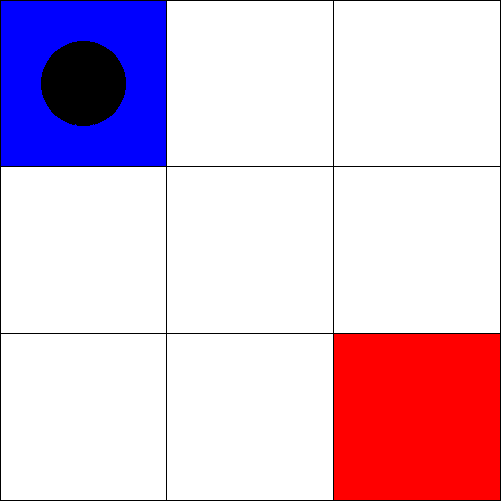

Reward for Episode:  0  ->  -1533.0
Reward for Episode:  1  ->  -2115.0
Reward for Episode:  2  ->  -505.0
Reward for Episode:  3  ->  -115.0
Reward for Episode:  4  ->  -3.0
Reward for Episode:  5  ->  -709.0
Reward for Episode:  6  ->  -703.0
Reward for Episode:  7  ->  -5.0
Reward for Episode:  8  ->  -9.0
Reward for Episode:  9  ->  -3.0
Reward for Episode:  10  ->  -3.0
Reward for Episode:  11  ->  -7.0
Reward for Episode:  12  ->  -11.0
Reward for Episode:  13  ->  -109.0
Reward for Episode:  14  ->  -3.0
Reward for Episode:  15  ->  -3.0
Reward for Episode:  16  ->  -7.0
Reward for Episode:  17  ->  -3.0
Reward for Episode:  18  ->  -3.0
Reward for Episode:  19  ->  -3.0
Reward for Episode:  20  ->  -3.0
Reward for Episode:  21  ->  -3.0
Reward for Episode:  22  ->  -3.0
Reward for Episode:  23  ->  -3.0
Reward for Episode:  24  ->  -3.0
Reward for Episode:  25  ->  -3.0
Reward for Episode:  26  ->  -3.0
Reward for Episode:  27  ->  -105.0
Reward for Episode:  28  ->  -3.0
Rewar

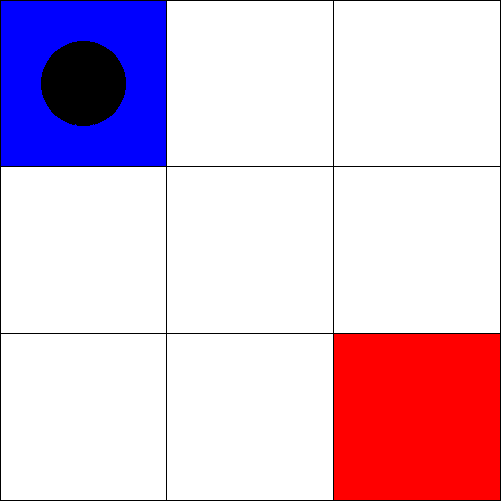

[[-53.21388218 -72.07228163  -7.37003254 -24.10657224]
 [-39.84663576 -23.53892176  -4.91908181 -28.0329333 ]
 [-54.53006856  -3.66838673  -5.09184058 -23.43685949]
 [ -4.94609671 -40.39892373 -10.05165594  -3.02601782]
 [ -9.49440442  -1.30623397 -27.34106672  -0.96393644]
 [ -8.18204914  -0.44974418   0.           0.        ]
 [ -1.92229284 -28.2313086  -20.20200142  -0.62880194]
 [ -0.68453772 -10.30100071 -50.38930185   0.        ]
 [  0.           0.           0.           0.        ]]
[[0.         0.         1.         0.        ]
 [0.02316275 0.02316275 0.93051174 0.02316275]
 [0.02316275 0.93051174 0.02316275 0.02316275]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [0.03177332 0.03177332 0.03177332 0.90468003]
 [0.03530369 0.03530369 0.03530369 0.89408892]
 [0.25       0.25       0.25       0.25      ]]


In [ ]:
reward_matrix = np.ones((3,3))*-1
reward_matrix[(2,2)] = 0
print(reward_matrix)
target_game = Targeting_Game( (3,3), (0,0), (2,2), reward_matrix)

on_policy_qtable = MC_OnPolicy_FirstVisit_QTable(target_game, \
                                       alpha=0.2, epsilon=0.5, discount=0.5, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.9)

agent = MCAgent(target_game, on_policy_qtable)
agent.play_game(1000)
agent.print_models()

### MC Off-Policy Testing

[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1.  0.]]


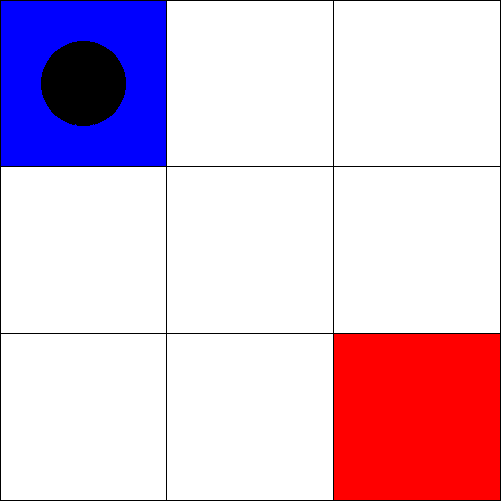

Reward for Episode:  0  ->  -1023.0
Reward for Episode:  1  ->  -3825.0
Reward for Episode:  2  ->  -605.0
Reward for Episode:  3  ->  -3.0
Reward for Episode:  4  ->  -3.0
Reward for Episode:  5  ->  -3.0
Reward for Episode:  6  ->  -3.0
Reward for Episode:  7  ->  -7.0
Reward for Episode:  8  ->  -405.0
Reward for Episode:  9  ->  -105.0
Reward for Episode:  10  ->  -9.0
Reward for Episode:  11  ->  -411.0
Reward for Episode:  12  ->  -107.0
Reward for Episode:  13  ->  -5.0
Reward for Episode:  14  ->  -107.0
Reward for Episode:  15  ->  -3.0
Reward for Episode:  16  ->  -9.0
Reward for Episode:  17  ->  -7.0
Reward for Episode:  18  ->  -103.0
Reward for Episode:  19  ->  -105.0
Reward for Episode:  20  ->  -7.0
Reward for Episode:  21  ->  -3.0
Reward for Episode:  22  ->  -3.0
Reward for Episode:  23  ->  -109.0
Reward for Episode:  24  ->  -3.0
Reward for Episode:  25  ->  -3.0
Reward for Episode:  26  ->  -211.0
Reward for Episode:  27  ->  -5.0
Reward for Episode:  28  ->  -10

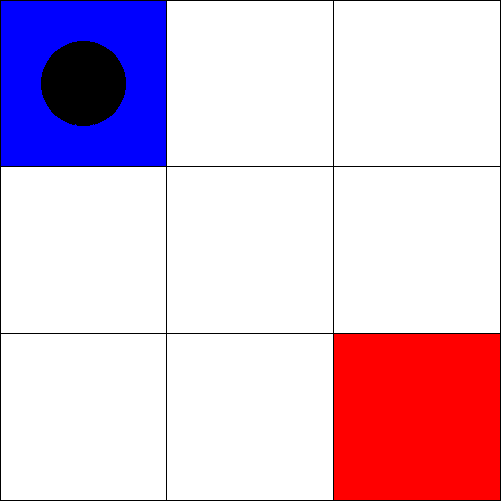

[[-105.19213119 -120.20870421   -5.21760523  -25.96063526]
 [-124.66800158   -2.0499195    -1.28801843  -21.25273312]
 [-101.26626971   -6.19968569   -6.8028169  -124.01791797]
 [ -22.03834044 -124.20280875  -21.07295645   -1.25571931]
 [  -1.44009149   -5.40768168  -21.08326114   -1.25030415]
 [  -1.25152074   -1.25064823    0.         -100.24996335]
 [  -2.20065344 -100.31764561 -100.44013069  -25.01435556]
 [  -2.08153664   -2.23019804 -118.2932        0.        ]
 [   0.            0.            0.            0.        ]]
[[0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]]
[[0.1  0.1  0.7  0.1 ]
 [0.1  0.1  0.7  0.1 ]
 [0.1  0.7  0.1  0.1 ]
 [0.1  0.1  0.1  0.7 ]
 [0.1  0.1  0.1  0.7 ]
 [0.1  0.1  0.7  0.1 ]
 [0.7  0.1  0.1  0.1 ]
 [0.1  0.1  0.1  0.7 ]
 [0.25 0.25 0.25 0.25]]


In [23]:
reward_matrix = np.ones((3,3))*-1
reward_matrix[(2,2)] = 0
print(reward_matrix)
target_game = Targeting_Game( (3,3), (0,0), (2,2), reward_matrix)

off_policy_qtable = MC_OffPolicy_QTable(target_game, \
                                       alpha=0.1, epsilon=0.4, discount=0.2, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=1)

agent = MCAgent(target_game, off_policy_qtable)
agent.play_game(100)
agent.print_models()

### TD Q-Learning Testing

[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  0.]]


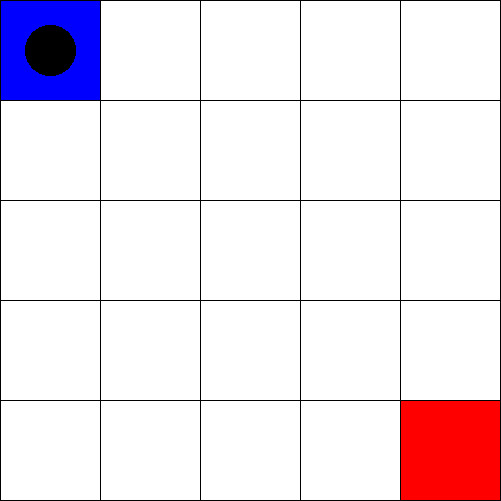

Reward for Episode:  0  ->  -5557.0 	 time steps:  311
Reward for Episode:  1  ->  -7.0 	 time steps:  8
Reward for Episode:  2  ->  -963.0 	 time steps:  73
Reward for Episode:  3  ->  -1169.0 	 time steps:  81
Reward for Episode:  4  ->  -1035.0 	 time steps:  46
Reward for Episode:  5  ->  -613.0 	 time steps:  20
Reward for Episode:  6  ->  -523.0 	 time steps:  29
Reward for Episode:  7  ->  -127.0 	 time steps:  29
Reward for Episode:  8  ->  -1397.0 	 time steps:  111
Reward for Episode:  9  ->  -749.0 	 time steps:  57
Reward for Episode:  10  ->  -635.0 	 time steps:  42
Reward for Episode:  11  ->  -1065.0 	 time steps:  76
Reward for Episode:  12  ->  -943.0 	 time steps:  53
Reward for Episode:  13  ->  -209.0 	 time steps:  12
Reward for Episode:  14  ->  -19.0 	 time steps:  20
Reward for Episode:  15  ->  -1019.0 	 time steps:  30
Reward for Episode:  16  ->  -317.0 	 time steps:  21
Reward for Episode:  17  ->  -13.0 	 time steps:  14
Reward for Episode:  18  ->  -117.0

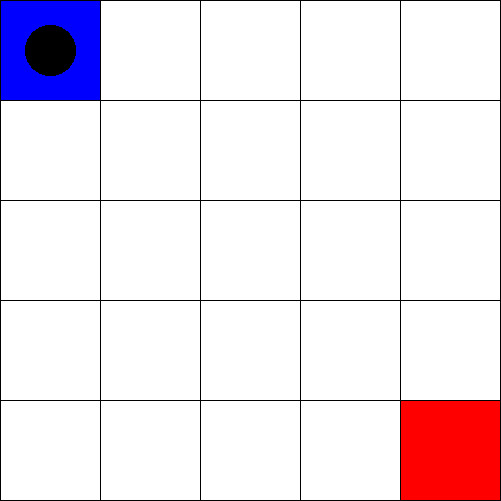

[[-81.0936435  -90.8610774   -2.1280109   -2.1280109 ]
 [-93.60841443  -1.90700411  -1.83557237  -1.83557237]
 [-68.86525739  -1.5689019   -1.51830075  -1.51830075]
 [-53.36829315  -1.3326084   -1.34694765  -1.33260839]
 [-61.37312127  -1.21428485  -1.21427994 -67.15845665]
 [ -1.85540209 -90.59120887  -1.87115344  -1.85540208]
 [ -2.07626831  -1.86853161  -1.53303384  -1.53303384]
 [ -1.39788682  -1.39788682  -1.48687003  -1.39788682]
 [ -1.22535541  -1.31357811  -1.24564075  -1.22513397]
 [ -0.99420752  -1.28901023  -0.99414286 -53.12895882]
 [ -1.66422723 -69.14978928  -1.6076101   -1.60763006]
 [ -1.5522835   -1.63688595  -1.38896622  -1.39024747]
 [ -1.17848575  -1.41936155  -1.16645018  -1.19103603]
 [ -1.10352793  -1.14305781  -0.97126371  -0.97488271]
 [ -0.68784282  -1.12802759  -0.65180518 -75.8192351 ]
 [ -1.47890897 -68.6968092   -1.47985072  -1.42707584]
 [ -1.37058035  -1.38322591  -1.27823887  -1.27930137]
 [ -1.18648425  -1.41754242  -1.20676241  -0.96157379]
 [ -0.7591

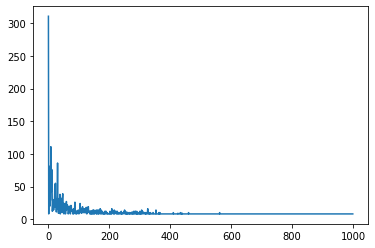

In [16]:
reward_matrix = np.ones((5,5))*-1
reward_matrix[(4,4)] = 0
print(reward_matrix)
target_game = Targeting_Game( (5,5), (0,0), (4,4), reward_matrix)

qlearning_qtable = QLearningQTable(target_game, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

agent = TDAgent(target_game, qlearning_qtable)
agent.play_game(1000)
agent.print_models()

### n-step Sarsa Testing

In [ ]:
reward_matrix = np.ones((5,5))*-1
reward_matrix[(3,3)] = 0
print(reward_matrix)
target_game = Targeting_Game( (5,5), (0,0), (3,3), reward_matrix)

nstep_sarsa_qtable = nstepSarsaQTable(target_game, n = 3, \
                                       alpha=0.2, epsilon=0.8, discount=0.2, \
                                       alpha_decay_rate = 0.99, epsilon_decay_rate=0.99)

agent = nstepTDAgent(target_game, nstep_sarsa_qtable)
agent.play_game(1000)
agent.print_models()

### n-step Tree Backup Testing

In [ ]:
reward_matrix = np.ones((5,5))*-1
reward_matrix[(3,3)] = 0
print(reward_matrix)
target_game = Targeting_Game( (5,5), (0,0), (3,3), reward_matrix)

nstep_backup_qtable = nstepBackupQTable(target_game, n = 1, \
                                       alpha=0.2, epsilon=0.8, discount=0.2, \
                                       alpha_decay_rate = 0.99, epsilon_decay_rate=0.99)

agent = nstepTDAgent(target_game, nstep_backup_qtable)
agent.play_game(1000)
agent.print_models()

### DynaQ Testing

In [ ]:
reward_matrix = np.ones((5,5))*-1
reward_matrix[(3,3)] = 0
print(reward_matrix)
target_game = Targeting_Game( (5,5), (0,0), (3,3), reward_matrix)

dynaq_qtable = DynaQTable(target_game, n = 1, \
                                       alpha=0.2, epsilon=0.5, discount=0.2, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.9)

agent = DynaQAgent(target_game, dynaq_qtable)
agent.play_game(1000)
agent.print_models()

## Collection Game Example

In [ ]:
reward_matrix = np.ones((5,5))*-1
reward_matrix[(2,2)] = 0
reward_matrix[(4,4)] = 0

collection_game = Collection_Game( (5,5), (0,0), [(2,2),(4,4)],reward_matrix)

qlearning_qtable = QLearningQTable(collection_game, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

agent = TDAgent(collection_game, qlearning_qtable)
agent.play_game(1000)
agent.print_models()


## FindMax Game Example

In [ ]:
board_size, start_state, reward_matrix = make_maxgame_grid((4,4))

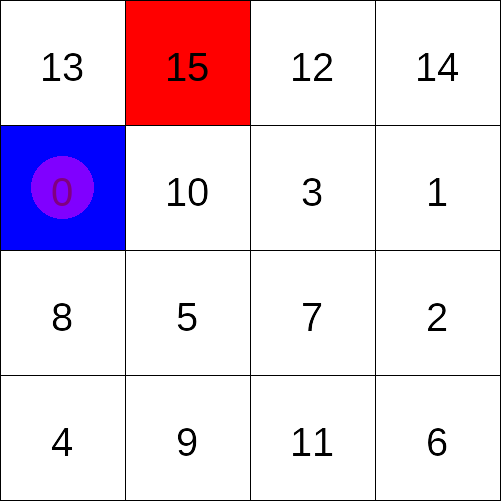

Reward for Episode:  0  ->  -579
Reward for Episode:  1  ->  -656
Reward for Episode:  2  ->  91
Reward for Episode:  3  ->  -135
Reward for Episode:  4  ->  -352
Reward for Episode:  5  ->  -7
Reward for Episode:  6  ->  147
Reward for Episode:  7  ->  102
Reward for Episode:  8  ->  28
Reward for Episode:  9  ->  -72
Reward for Episode:  10  ->  28
Reward for Episode:  11  ->  28
Reward for Episode:  12  ->  28
Reward for Episode:  13  ->  28
Reward for Episode:  14  ->  41
Reward for Episode:  15  ->  28
Reward for Episode:  16  ->  28
Reward for Episode:  17  ->  28
Reward for Episode:  18  ->  28
Reward for Episode:  19  ->  28
Reward for Episode:  20  ->  28
Reward for Episode:  21  ->  28
Reward for Episode:  22  ->  28
Reward for Episode:  23  ->  28
Reward for Episode:  24  ->  28
Reward for Episode:  25  ->  28
Reward for Episode:  26  ->  28
Reward for Episode:  27  ->  28
Reward for Episode:  28  ->  28
Reward for Episode:  29  ->  28
Reward for Episode:  30  ->  28
Reward 

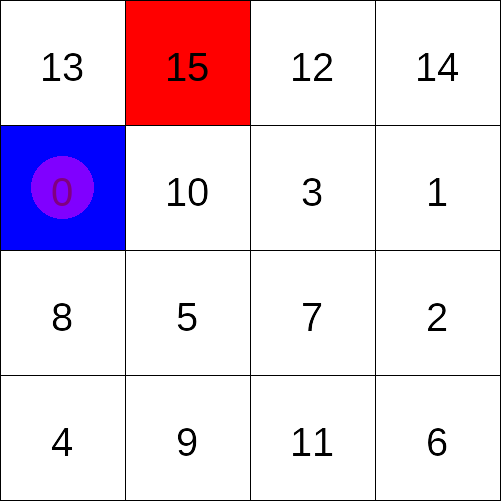

[[-13.56323782   0.           1.68254236  10.03942035]
 [  0.           0.           0.           0.        ]
 [-58.39637356  12.57235566   5.17591231  16.7385517 ]
 [-76.62899121  14.97846297   3.93022459 -94.35766246]
 [ 13.40938776 -63.24020393   8.91877157   0.        ]
 [  0.           0.           0.           4.24061038]
 [ 14.78309031   8.94878264   7.86996809   3.12367206]
 [ 15.40226877   4.80450733   1.85558769 -93.57454118]
 [  1.10801161   0.           0.           6.24789771]
 [  0.           0.           0.           7.86342191]
 [  5.6608647    0.           4.61929447   3.02329969]
 [  0.           7.6338753    5.54013642   0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  5.66130738   0.         -56.86242649   0.        ]
 [  2.84553689   0.         -92.75056364 -69.12047195]]
[[0.         0.         0.         1.        ]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.         0

In [ ]:
max_game = FindMax_Game(board_size, start_state, reward_matrix)

dynaq_qtable = DynaQTable(max_game, n = 1, \
                                       alpha=0.2, epsilon=0.5, discount=0.2, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.9)

agent = DynaQAgent(max_game, dynaq_qtable)
agent.play_game(200)

agent.print_models()

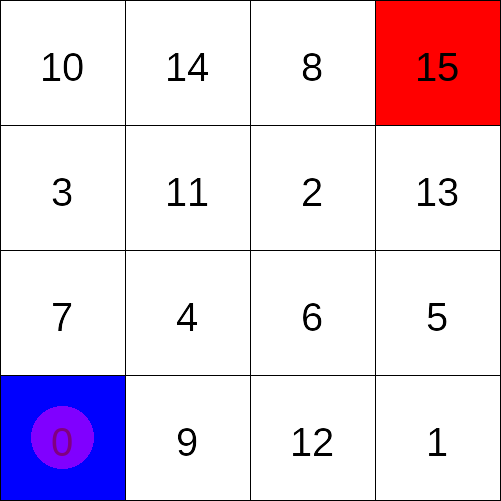

Reward for Episode:  0  ->  -487 	 time steps:  24
Reward for Episode:  1  ->  -327 	 time steps:  12
Reward for Episode:  2  ->  -5 	 time steps:  11
Reward for Episode:  3  ->  -48 	 time steps:  9
Reward for Episode:  4  ->  -48 	 time steps:  7
Reward for Episode:  5  ->  -41 	 time steps:  7
Reward for Episode:  6  ->  -194 	 time steps:  15
Reward for Episode:  7  ->  -3 	 time steps:  11
Reward for Episode:  8  ->  -18 	 time steps:  13
Reward for Episode:  9  ->  -32 	 time steps:  9
Reward for Episode:  10  ->  -204 	 time steps:  13
Reward for Episode:  11  ->  -142 	 time steps:  8
Reward for Episode:  12  ->  47 	 time steps:  23
Reward for Episode:  13  ->  141 	 time steps:  22
Reward for Episode:  14  ->  102 	 time steps:  16
Reward for Episode:  15  ->  58 	 time steps:  6
Reward for Episode:  16  ->  58 	 time steps:  6
Reward for Episode:  17  ->  83 	 time steps:  10
Reward for Episode:  18  ->  58 	 time steps:  6
Reward for Episode:  19  ->  57 	 time steps:  6
Re

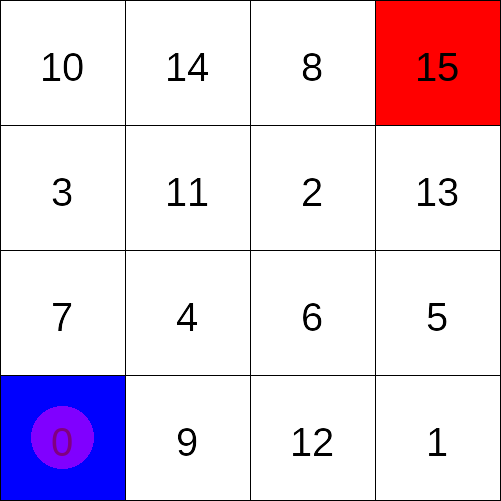

[[ -5.19406879  -2.11907164   1.62406518   0.05941448]
 [-35.15497157   0.80395238   0.82047784   7.07382469]
 [-13.83198647   2.2874665    0.787968     7.21759648]
 [  0.           0.           0.           0.        ]
 [  2.05082502 -29.85056091   1.81104783   9.53442536]
 [ 10.78938675   0.4172331    0.03331488   0.        ]
 [  1.52907071   0.           0.           4.01301438]
 [  5.00159875   0.05011356   0.         -22.56898785]
 [  4.6933883  -29.25994324   1.25541924   1.7194513 ]
 [  1.20810268   1.86726386   0.           3.59700947]
 [  0.78218787   2.33565764   0.56524815   0.4096    ]
 [  1.37725215   0.           0.           0.        ]
 [  6.96331964 -46.62001933 -36.38078301   1.12391329]
 [  0.72454058   0.           0.           0.        ]
 [  0.34328456   0.          -3.3554432    0.        ]
 [  0.           0.           0.           0.        ]]
[[0.00686737 0.00686737 0.9793979  0.00686737]
 [0.         0.         0.         1.        ]
 [0.         0.         0

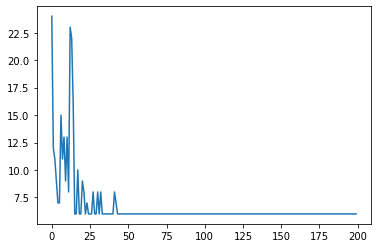

In [ ]:
max_game = FindMax_Game(board_size, start_state, reward_matrix)

qlearning_qtable = QLearningQTable(max_game, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.8, epsilon_decay_rate=0.9)

agent = TDAgent(max_game, qlearning_qtable)
agent.play_game(200)
agent.print_models()

In [ ]:
reward_matrix = np.asarray([[1,2,3,4,5], [6,7,8,9,10], [11,12,13,14,15], [16,17,18,19,20],[21,22,23,24,25]])

max_game = FindMax_Game( (5,5), (2,0), reward_matrix)

qlearning_qtable = QLearningQTable(max_game, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

agent = TDAgent(max_game, qlearning_qtable)
agent.play_game(1000)
agent.print_models()

## MaxPath Game Example

In [ ]:
reward_matrix = np.asarray([[1,2,3,4,5], [6,7,8,9,10], [11,12,13,14,15], [16,17,18,19,20],[21,22,23,24,25]])

max_game = MaxPath_Game( (5,5), (0,0), reward_matrix)

qlearning_qtable = QLearningQTable(max_game, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

agent = TDAgent(max_game, qlearning_qtable)
agent.play_game(1000)
agent.print_models()

# Multi-Task Testing

## Q-Learning

[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  0.]]


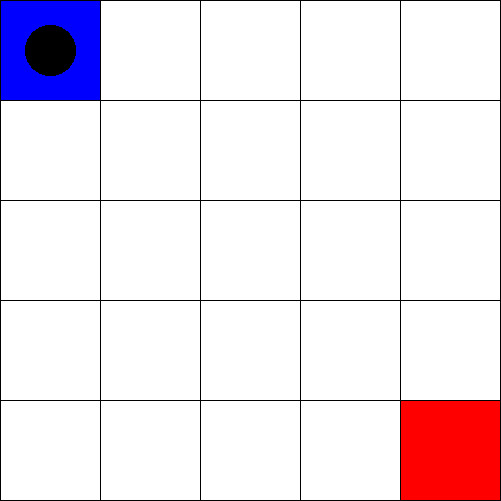

Reward for Episode:  0  ->  -319.0 	 time steps:  23
Reward for Episode:  1  ->  -1023.0 	 time steps:  34
Reward for Episode:  2  ->  -2159.0 	 time steps:  81
Reward for Episode:  3  ->  -1469.0 	 time steps:  84
Reward for Episode:  4  ->  -1199.0 	 time steps:  111
Reward for Episode:  5  ->  -1683.0 	 time steps:  100
Reward for Episode:  6  ->  -139.0 	 time steps:  41
Reward for Episode:  7  ->  -941.0 	 time steps:  51
Reward for Episode:  8  ->  -111.0 	 time steps:  13
Reward for Episode:  9  ->  -427.0 	 time steps:  32
Reward for Episode:  10  ->  -637.0 	 time steps:  44
Reward for Episode:  11  ->  -517.0 	 time steps:  23
Reward for Episode:  12  ->  -109.0 	 time steps:  11
Reward for Episode:  13  ->  -225.0 	 time steps:  28
Reward for Episode:  14  ->  -1329.0 	 time steps:  142
Reward for Episode:  15  ->  -615.0 	 time steps:  22
Reward for Episode:  16  ->  -765.0 	 time steps:  73
Reward for Episode:  17  ->  -419.0 	 time steps:  24
Reward for Episode:  18  ->  

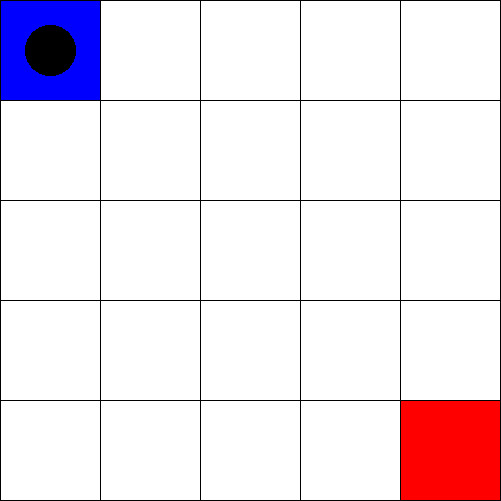

[[-73.89793265 -86.15212609  -1.66749725  -1.66749725]
 [-72.23229338  -1.44579618  -1.39411715  -1.39411715]
 [-83.42824803  -1.18852951  -1.18850359  -1.18850359]
 [-78.518204    -1.04373122  -0.90424717  -0.90424717]
 [-56.98976246  -0.90672133  -0.88730632 -40.05799852]
 [ -1.40309766 -78.42085793  -1.40247754  -1.40247754]
 [ -1.25520524  -1.25560817  -1.25520524  -1.25520524]
 [ -1.07909809  -1.08228902  -1.07909809  -1.07909809]
 [ -0.91889935  -0.91890282  -0.91889935  -0.91889935]
 [ -0.86220312  -0.84517649  -0.84517649 -48.38519419]
 [ -1.19627729 -65.07406636  -1.19627729  -1.24021666]
 [ -1.1008096   -1.1377542   -1.15934807  -1.1008096 ]
 [ -0.88855393  -1.2115486   -0.88421761  -0.88421761]
 [ -0.79204958  -0.79231388  -0.784968    -0.78498292]
 [ -0.74440573  -0.673238    -0.60450536 -37.07193369]
 [ -1.05215424 -59.50661422  -1.05387343  -1.05182562]
 [ -1.03963545  -0.9529624   -0.97791529  -0.9529624 ]
 [ -0.76251563  -0.7281773   -0.7281773   -0.75024141]
 [ -0.6577

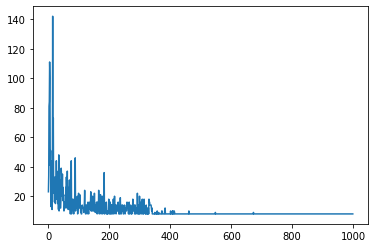

In [ ]:
start = (0,0)
final = (3,3)
reward_matrix = np.ones((5,5))*-1
reward_matrix[final] = 0
print(reward_matrix)
target_game1 = Targeting_Game( (5,5), start, final, reward_matrix)

qlearning_qtable1 = QLearningQTable(target_game1, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

qagent1 = TDAgent(target_game1, qlearning_qtable1)
qagent1.play_game(1000)
qagent1.print_models()

[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1.  0. -1.]
 [-1. -1. -1. -1. -1.]]


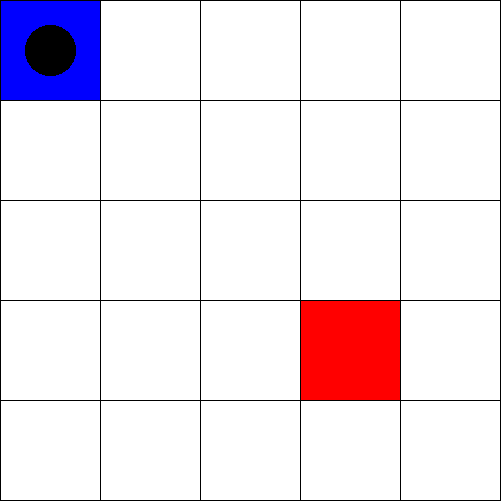

Reward for Episode:  0  ->  -537.0 	 time steps:  43
Reward for Episode:  1  ->  -1249.0 	 time steps:  62
Reward for Episode:  2  ->  -641.0 	 time steps:  48
Reward for Episode:  3  ->  -309.0 	 time steps:  13
Reward for Episode:  4  ->  -1335.0 	 time steps:  49
Reward for Episode:  5  ->  -215.0 	 time steps:  18
Reward for Episode:  6  ->  -1155.0 	 time steps:  67
Reward for Episode:  7  ->  -213.0 	 time steps:  16
Reward for Episode:  8  ->  -615.0 	 time steps:  22
Reward for Episode:  9  ->  -421.0 	 time steps:  26
Reward for Episode:  10  ->  -513.0 	 time steps:  19
Reward for Episode:  11  ->  -9.0 	 time steps:  10
Reward for Episode:  12  ->  -725.0 	 time steps:  33
Reward for Episode:  13  ->  -315.0 	 time steps:  19
Reward for Episode:  14  ->  -839.0 	 time steps:  48
Reward for Episode:  15  ->  -107.0 	 time steps:  9
Reward for Episode:  16  ->  -213.0 	 time steps:  16
Reward for Episode:  17  ->  -311.0 	 time steps:  15
Reward for Episode:  18  ->  -209.0 	 

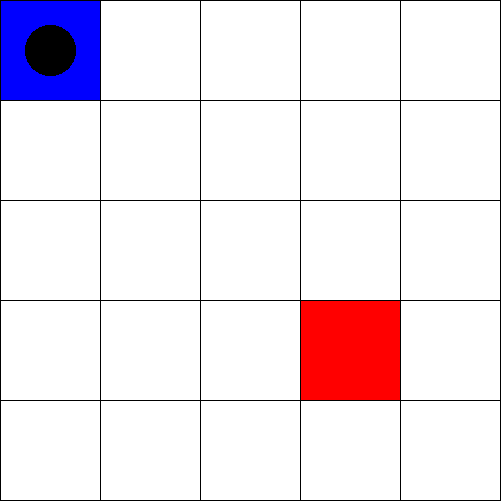

[[-82.91726387 -82.09771841  -1.47400458  -1.47400458]
 [-73.71200592  -1.20288183  -1.11126489  -1.11126489]
 [-29.99929087  -0.84752264  -0.80218638  -0.85587246]
 [-30.10844266  -0.71909291  -0.79574988  -0.80746245]
 [-35.84688589  -0.82300311  -0.57476457 -44.81383929]
 [ -1.12708105 -61.5876809   -1.12708105  -1.12708105]
 [ -0.94773359  -0.94728878  -0.94728877  -0.94728877]
 [ -0.73269047  -0.73277962  -0.97490782  -0.73269047]
 [ -0.75662695  -0.5867747   -0.61134702  -0.55986834]
 [ -0.62198174  -0.57239989  -0.32766676 -15.19555475]
 [ -0.88187015 -66.42025794  -0.82240242  -0.80335985]
 [ -0.73471946  -0.77041904  -0.73471938  -0.91816303]
 [ -0.60720815  -0.76335449  -0.51230551  -0.55595108]
 [ -0.6094214   -0.2186364    0.          -0.17176493]
 [ -0.1347889   -0.1347889   -0.35991031  -9.51492606]
 [ -0.66630485 -61.12344827  -0.6634619   -0.6586478 ]
 [ -0.55023518  -0.56010914  -0.57900624  -0.545513  ]
 [ -0.40980683  -0.48859361  -0.18408943   0.        ]
 [  0.    

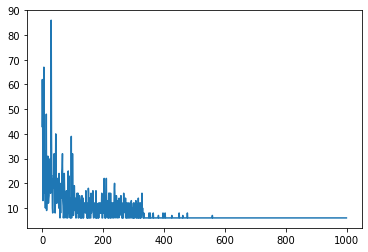

In [ ]:
start = (0,0)
final = (3,3)
reward_matrix = np.ones((5,5))*-1
reward_matrix[final] = 0
print(reward_matrix)
target_game2 = Targeting_Game( (5,5), start, final, reward_matrix)

qlearning_qtable2 = QLearningQTable(target_game2, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.99)

qagent2 = TDAgent(target_game2, qlearning_qtable2)
qagent2.play_game(1000)
qagent2.print_models()

In [ ]:
print(qagent1.model.qtable)
print(qagent2.model.qtable)

x = qagent1.model.qtable
y = qagent2.model.qtable
mse = 0
t = 0

diffs = [xi-yi for xi,yi in zip(x.flatten(),y.flatten())]

print(np.reshape(diffs, (np.shape(x))))
print(np.median(diffs))
# for r in range(np.shape(x)[0]):
#     for c in range(np.shape(x)[1]):
#         t += 1
#         mse += 1/t * ((x[r,c]-y[r,c])**2 - mse)
# mse

[[-73.89793265 -86.15212609  -1.66749725  -1.66749725]
 [-72.23229338  -1.44579618  -1.39411715  -1.39411715]
 [-83.42824803  -1.18852951  -1.18850359  -1.18850359]
 [-78.518204    -1.04373122  -0.90424717  -0.90424717]
 [-56.98976246  -0.90672133  -0.88730632 -40.05799852]
 [ -1.40309766 -78.42085793  -1.40247754  -1.40247754]
 [ -1.25520524  -1.25560817  -1.25520524  -1.25520524]
 [ -1.07909809  -1.08228902  -1.07909809  -1.07909809]
 [ -0.91889935  -0.91890282  -0.91889935  -0.91889935]
 [ -0.86220312  -0.84517649  -0.84517649 -48.38519419]
 [ -1.19627729 -65.07406636  -1.19627729  -1.24021666]
 [ -1.1008096   -1.1377542   -1.15934807  -1.1008096 ]
 [ -0.88855393  -1.2115486   -0.88421761  -0.88421761]
 [ -0.79204958  -0.79231388  -0.784968    -0.78498292]
 [ -0.74440573  -0.673238    -0.60450536 -37.07193369]
 [ -1.05215424 -59.50661422  -1.05387343  -1.05182562]
 [ -1.03963545  -0.9529624   -0.97791529  -0.9529624 ]
 [ -0.76251563  -0.7281773   -0.7281773   -0.75024141]
 [ -0.6577

In [ ]:
print(qagent1.model.target_policy)
print(qagent2.model.target_policy)

[[0.00000872 0.00000872 0.99997384 0.00000872]
 [0.00023564 0.00023564 0.00023564 0.99929309]
 [0.00023564 0.00023564 0.00023564 0.99929309]
 [0.00023564 0.00023564 0.99929309 0.00023564]
 [0.00718256 0.00718256 0.97845231 0.00718256]
 [0.00000872 0.00000872 0.99997384 0.00000872]
 [0.00718256 0.00718256 0.97845231 0.00718256]
 [0.00725511 0.00725511 0.97823466 0.00725511]
 [0.00023564 0.00023564 0.99929309 0.00023564]
 [0.00718256 0.97845231 0.00718256 0.00718256]
 [0.00000872 0.00000872 0.99997384 0.00000872]
 [0.00194471 0.00194471 0.00194471 0.99416587]
 [0.00194471 0.00194471 0.00194471 0.99416587]
 [0.00023564 0.00023564 0.99929309 0.00023564]
 [0.00718256 0.00718256 0.97845231 0.00718256]
 [0.00000872 0.00000872 0.00000872 0.99997384]
 [0.00000872 0.00000872 0.00000872 0.99997384]
 [0.00000872 0.00000872 0.99997384 0.00000872]
 [0.00023564 0.00023564 0.00023564 0.99929309]
 [0.00023564 0.00023564 0.99929309 0.00023564]
 [0.00381326 0.00381326 0.00381326 0.98856021]
 [0.00257673 

## DynaQ

[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.]]


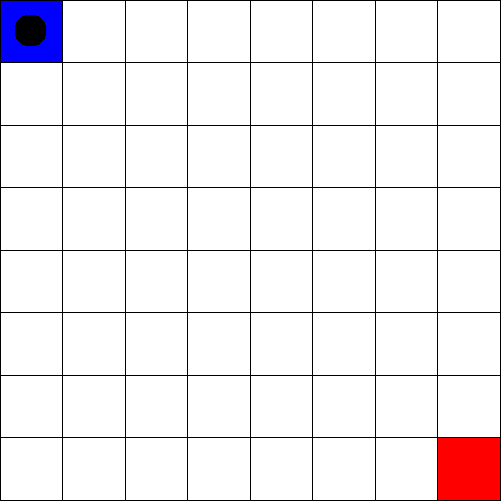

Reward for Episode:  0  ->  -10055.0
Reward for Episode:  1  ->  -1175.0
Reward for Episode:  2  ->  -4225.0
Reward for Episode:  3  ->  -341.0
Reward for Episode:  4  ->  -47.0
Reward for Episode:  5  ->  -553.0
Reward for Episode:  6  ->  -433.0
Reward for Episode:  7  ->  -23.0
Reward for Episode:  8  ->  -645.0
Reward for Episode:  9  ->  -325.0
Reward for Episode:  10  ->  -335.0
Reward for Episode:  11  ->  -125.0
Reward for Episode:  12  ->  -335.0
Reward for Episode:  13  ->  -127.0
Reward for Episode:  14  ->  -21.0
Reward for Episode:  15  ->  -31.0
Reward for Episode:  16  ->  -17.0
Reward for Episode:  17  ->  -131.0
Reward for Episode:  18  ->  -115.0
Reward for Episode:  19  ->  -217.0
Reward for Episode:  20  ->  -217.0
Reward for Episode:  21  ->  -13.0
Reward for Episode:  22  ->  -413.0
Reward for Episode:  23  ->  -113.0
Reward for Episode:  24  ->  -15.0
Reward for Episode:  25  ->  -19.0
Reward for Episode:  26  ->  -123.0
Reward for Episode:  27  ->  -123.0
Reward

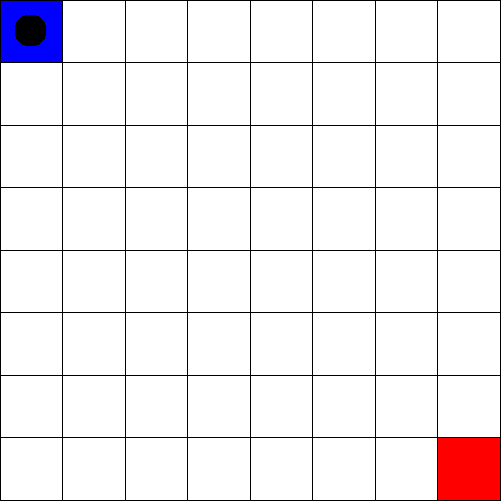

[[-104.75213085 -104.99531922   -5.75358781   -5.66973406]
 [-104.19246219   -5.91186132   -5.32032307   -5.27026138]
 [-104.10666118   -5.38528259   -4.93324126   -4.93662854]
 [-103.96782336   -5.01742349   -4.73791582   -4.83994024]
 [-103.67570218   -4.83857821   -4.52421479   -4.63612796]
 [-103.37583762   -4.86180228   -4.27260165   -4.35366579]
 [-103.3774854    -4.47771608   -4.17919674   -4.39605004]
 [-103.05852922   -4.29871727   -4.23303412 -103.53031261]
 [  -5.81452491 -104.61344242   -5.37370691   -5.30986438]
 [  -5.22331878   -5.64304272   -5.07316908   -5.0721103 ]
 [  -4.91940784   -5.19883228   -4.7673803    -4.67788806]
 [  -4.81728261   -4.90923337   -4.42488388   -4.72625095]
 [  -4.9152506    -4.65552864   -4.29642283   -4.2771587 ]
 [  -4.3936674    -4.57095259   -3.87752914   -4.12716072]
 [  -4.30657361   -4.33178308   -4.0591648    -4.13888144]
 [  -4.35163031   -4.33250968   -3.70359099 -103.12803534]
 [  -5.61006481 -104.07387724   -5.08749094   -5.0356743

In [ ]:
start = (0,0)
final = (7,7)
board = (8,8)
reward_matrix = np.ones(board)*-1
reward_matrix[final] = 0
print(reward_matrix)
target_game1 = Targeting_Game( board, start, final, reward_matrix)

dynaq_qtable1 = DynaQTable(target_game1, n = 10, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.95)

dqagent1 = DynaQAgent(target_game1, dynaq_qtable1)
dqagent1.play_game(1000)
dqagent1.print_models()

[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.]]


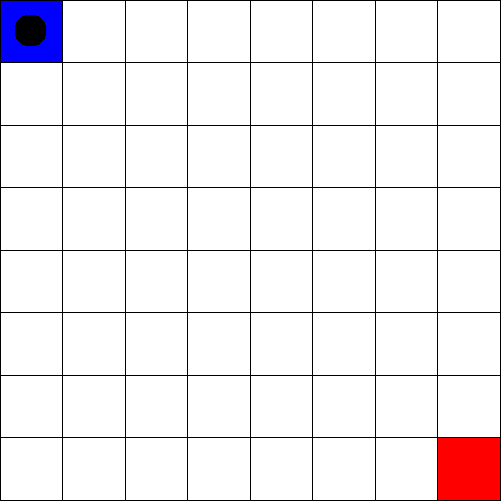

Reward for Episode:  0  ->  -2043.0
Reward for Episode:  1  ->  -2931.0
Reward for Episode:  2  ->  -2513.0
Reward for Episode:  3  ->  -921.0
Reward for Episode:  4  ->  -293.0
Reward for Episode:  5  ->  -3111.0
Reward for Episode:  6  ->  -339.0
Reward for Episode:  7  ->  -803.0
Reward for Episode:  8  ->  -125.0
Reward for Episode:  9  ->  -239.0
Reward for Episode:  10  ->  -121.0
Reward for Episode:  11  ->  -429.0
Reward for Episode:  12  ->  -125.0
Reward for Episode:  13  ->  -17.0
Reward for Episode:  14  ->  -131.0
Reward for Episode:  15  ->  -115.0
Reward for Episode:  16  ->  -333.0
Reward for Episode:  17  ->  -115.0
Reward for Episode:  18  ->  -115.0
Reward for Episode:  19  ->  -217.0
Reward for Episode:  20  ->  -117.0
Reward for Episode:  21  ->  -127.0
Reward for Episode:  22  ->  -121.0
Reward for Episode:  23  ->  -19.0
Reward for Episode:  24  ->  -117.0
Reward for Episode:  25  ->  -15.0
Reward for Episode:  26  ->  -113.0
Reward for Episode:  27  ->  -15.0
Re

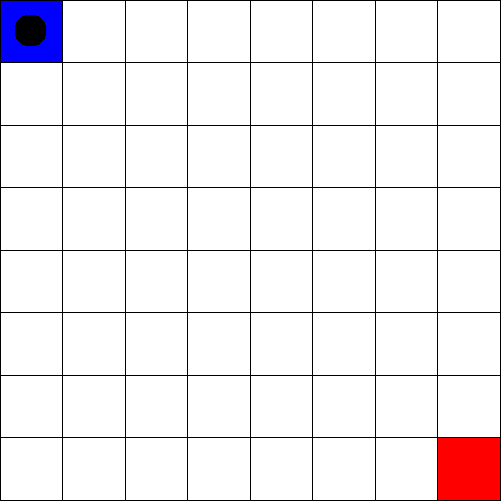

[[-103.78652553 -103.50853704   -4.99366336   -4.94113416]
 [-103.65237466   -4.85883892   -4.63629622   -4.72410616]
 [-103.37874422   -4.54742137   -4.63724161   -4.73899052]
 [-103.43169975   -4.7385506    -4.41217576   -4.74935059]
 [-103.66905619   -4.77504111   -4.45649459   -4.81053639]
 [-103.64098153   -4.6102291    -4.49684731   -4.74105046]
 [-103.11987904   -4.60999981   -4.64821815   -4.50987405]
 [-103.5457516    -4.38126031   -4.8698708  -103.6022336 ]
 [  -4.8923749  -103.86979366   -4.75115466   -4.76587293]
 [  -4.75290712   -4.78521023   -4.67429625   -4.65813703]
 [  -4.70973428   -4.78278766   -4.49860828   -4.54441844]
 [  -4.66782942   -4.53882234   -4.14552687   -4.53011449]
 [  -4.72526763   -4.40451521   -4.169904     -4.45172007]
 [  -4.66949439   -4.36948099   -4.12381406   -4.66325574]
 [  -4.70623043   -4.51953453   -4.45076154   -4.84774044]
 [  -4.57091318   -4.77341548   -4.36192038 -103.91809471]
 [  -4.93163289 -103.59499232   -4.51087367   -4.5725616

In [ ]:
start = (0,0)
final = (7,7)
board = (8,8)
reward_matrix = np.ones(board)*-1
reward_matrix[final] = 0
print(reward_matrix)
target_game2 = Targeting_Game( board, start, final, reward_matrix)

dynaq_qtable2 = DynaQTable(target_game2, n = 10, \
                                       alpha=0.2, epsilon=0.8, discount=0.95, \
                                       alpha_decay_rate = 0.9, epsilon_decay_rate=0.95)

dqagent2 = DynaQAgent(target_game2, dynaq_qtable2)
dqagent2.play_game(1000)
dqagent2.print_models()

In [ ]:
print(dqagent1.model.qtable)
print(dqagent2.model.qtable)

x = dqagent1.model.qtable
y = dqagent2.model.qtable
mse = 0
t = 0

diffs = [xi-yi for xi,yi in zip(x.flatten(),y.flatten())]

print(np.reshape(diffs, (np.shape(x))))
print(np.median(np.abs(diffs)))

[[-103.51847638 -103.51407176   -4.42562562   -3.81588293]
 [-102.79339969   -4.52703999   -3.69845388   -3.12521417]
 [-102.02864571   -3.78596766   -2.92730387   -2.5142924 ]
 [-101.44502346   -3.05833703   -2.20785362   -2.01496566]
 [-100.77939381   -2.44762722   -1.51791496  -88.92833851]
 [  -4.52183332 -103.42833189   -4.01356256   -3.69634233]
 [  -3.79672855   -4.41276026   -3.30135763   -2.92045976]
 [  -3.03077667   -3.70809103   -2.57443017   -2.22033362]
 [  -2.45677094   -2.91727306   -1.90321571   -1.55107433]
 [  -1.97840027   -2.14342693   -0.88386123  -79.16637909]
 [  -4.42722311 -102.97564763   -3.38341684   -3.30056694]
 [  -3.67515612   -3.99746056   -2.70988238   -2.61597812]
 [  -2.91652033   -3.30262487   -1.8457881    -1.92381326]
 [  -2.14838303   -2.61124712   -0.99837337   -0.99999939]
 [  -1.3300098    -1.91366786    0.          -99.99912835]
 [  -3.98160657 -102.45328518   -3.9106285    -2.68508496]
 [  -3.33447089   -3.41212914   -3.35164232   -1.9144578

In [ ]:
print(dqagent1.model.target_policy)
print(dqagent2.model.target_policy)

x = dqagent1.model.target_policy
y = dqagent2.model.target_policy
mse = 0
t = 0

diffs = [xi-yi for xi,yi in zip(x.flatten(),y.flatten())]

print(np.reshape(diffs, (np.shape(x))))
print(np.mean(np.abs(diffs)))

[[0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.  

In [ ]:
def softmax(X):
    e_X = np.exp(X)
    return e_X / np.sum(e_X)

x = dqagent1.model.qtable
y = dqagent2.model.qtable

new_x = np.reshape([softmax(xi) for i,xi in enumerate(x)], (np.shape(x)))
new_y = np.reshape([softmax(yi) for i,yi in enumerate(y)], (np.shape(y)))

print(new_x)
print(new_y)

diffs = [xi-yi for xi,yi in zip(new_x.flatten(),new_y.flatten())]

print(np.reshape(diffs, (np.shape(x))))
print(np.mean(np.abs(diffs)))

[[0.         0.         0.47904884 0.52095116]
 [0.         0.2124819  0.38390498 0.40361311]
 [0.         0.24167901 0.37980265 0.37851833]
 [0.         0.28435858 0.37605812 0.3395833 ]
 [0.         0.27825805 0.38104304 0.34069892]
 [0.         0.22397732 0.40372963 0.37229304]
 [0.         0.29129424 0.39262432 0.31608145]
 [0.         0.48358511 0.51641489 0.        ]
 [0.23750707 0.         0.36908073 0.3934122 ]
 [0.2511001  0.16503007 0.29178037 0.29208946]
 [0.23845896 0.18032716 0.27761208 0.3036018 ]
 [0.22281731 0.20324282 0.32988725 0.24405262]
 [0.16539354 0.21444422 0.30709449 0.31306775]
 [0.20753425 0.17381842 0.34773289 0.27091444]
 [0.22530739 0.21969851 0.28855176 0.26644233]
 [0.25438216 0.2592929  0.48632494 0.        ]
 [0.22409415 0.         0.37790398 0.39800187]
 [0.21141819 0.18609506 0.30653678 0.29594996]
 [0.1740426  0.16544467 0.32999081 0.33052192]
 [0.20173617 0.17339233 0.32766975 0.29720174]
 [0.17751242 0.18699812 0.31716839 0.31832107]
 [0.18966421 

# Old Code

In [ ]:
class DynaQAgentOLD:
    """
    This class implements a temporal difference off-policy (qlearning) agent that can play grid games
    """
    def __init__(self, Game, QTable, epsilon, policy_update_steps=50, n_planning_steps = 50, epsilon_decay_rate=1.0):
        self.Game = Game
        self.QTable = QTable
        self.planning_model = np.zeros_like(self.QTable.matrix)
        self.behavior_policy = np.ones_like(self.QTable.matrix) / len(self.Game.moves)
        self.target_policy = None
        self.epsilon = epsilon
        self.policy_update_steps = policy_update_steps
        self.n_planning_steps = n_planning_steps
        self.epsilon_decay_rate = epsilon_decay_rate # \in [0.5, 1]
        
    def get_target_policy(self):
        """
        This function obtains the deterministic (greedy) policy from the qtable
        """
        self.QTable.get_target_policy()
        self.target_policy = self.QTable.target_policy
    
    def update_models(self, state, action, reward, new_state):
        """
        state - a tuple point corresponding to a square in a grid game
        action - a tuple move corresponding to an action made in a grid game
        reward - the reward derived from the game's reward matrix for specific action taken in specific state
        new_state - a tuple point corresponding to the square in the grid game that your agent moved to 
            from taking the action described above in the state described above
        This function updates the qtable by calling update_qtable and passing the necessary information about the game environment
        """
        new_state_idx = self.Game.point_to_index(new_state)
        state_idx = self.Game.point_to_index(state)
        action_idx = self.Game.moves.index(action)
        self.QTable.update_qtable(state_idx, action_idx, reward, new_state_idx)
        self.planning_model[state_idx, action_idx] = reward
    
    def update_planning(self):
        for n in range(self.n_planning_steps):
            random_state_idx = random.randint(0, self.Game.width*self.Game.height)
            random_action_idx = random.randint(0,len(self.Game.moves))
            reward = self.planning_model[random_state_idx, random_action_idx]
            new_state_idx = self.Game.point_to_index(tuple(np.array(self.Game.agent_pos) + np.array(self.Game.moves[random_action_idx])))
            self.QTable.update_qtable(random_state_idx, random_action_idx, reward, new_state_idx)

    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.Game.moves[random.randint(0,len(self.Game.moves))]


    def epsilon_decay (self):
      self.epsilon = self.epsilon*self.epsilon_decay_rate


    def update_behavior_policy(self):
        "Updates behavior table with the probability values of a given state index, must update QTable first"
        for state_idx in range(len(self.behavior_policy)):
            max_action_idx = np.argmax(self.QTable.matrix[state_idx])
        
            for x in range(0,len(self.Game.moves)):
                self.behavior_policy[state_idx][x] = self.epsilon/len(self.Game.moves)
            self.behavior_policy[state_idx][max_action_idx] = 1-self.epsilon + self.epsilon/len(self.Game.moves)
        
        self.update_planning()
        self.epsilon_decay()
        self.print_policies()
        print(self.QTable.matrix)

        
    def update_terminal_state_returns(self):
        #learn max lookahead for actions in the terminal state
        terminal_state = self.Game.agent_pos
        for iters in range(5*len(self.Game.moves)):
            self.Game.agent_pos = terminal_state

            #get possible moves going up, left, down, and right
            new_action = self.get_action(self.Game.agent_pos)
            new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

            #if move is illegal (going off the board), set reward to very bad
            if self.Game.illegal_move(new_state):
                reward = -10000
                self.update_models(self.Game.agent_pos, new_action, reward, self.Game.agent_pos)
                self.Game.update_state(tuple(new_state), True)
            else:
            #else the selected move is legal and we should get reward r for agent going to state s'
                reward = self.Game.get_reward(new_state)
                self.update_models(self.Game.agent_pos, new_action, reward, new_state)
                self.Game.update_state(tuple(new_state), False)

        self.QTable.incidence = np.zeros_like(self.QTable.matrix)

    def print_policies(self):
        print("Behavior Policy")
        print(self.behavior_policy)
        print("Target Policy")
        print(self.target_policy)
        print("Planning Model")
        print(self.planning_model)

    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)

            t = 0
            episode_reward = 0
            
            if (i % self.policy_update_steps) + 1 == self.policy_update_steps:
                print("update at step: ",i)
                self.update_behavior_policy()

            #while agent is not in a terminal state
            while not self.Game.is_episode_terminal():
                #Take action A, get reward R, step into s'
                #Find a that is max(s',a)

                if output:
                    print("Player's position",self.Game.agent_pos)

                t += 1

                #get possible moves going up, left, down, and right
                new_action = self.get_action(self.Game.agent_pos)
                new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

                #if move is illegal (going off the board), set reward to very bad
                if self.Game.illegal_move(new_state):
                    reward = -10000
                    self.update_models(self.Game.agent_pos, new_action, reward, self.Game.agent_pos)
                    self.Game.update_state(tuple(new_state), True)
                else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                    reward = self.Game.get_reward(new_state)
                    self.update_models(self.Game.agent_pos, new_action, reward, new_state)
                    self.Game.update_state(tuple(new_state), False)

                episode_reward += reward

                
#                 print("Player's possible moves: ",self.Game.get_moves(self.Game.agent_pos))
#                 print("Player's chosen move",new_state)
#                 print("Player's new position",self.Game.agent_pos)
#                 print("Player's reward for this move",reward)
#                 print("Number of moves made to perform task: ",t)

                # if self.Game.terminal_state is not None and self.Game.agent_pos in self.Game.terminal_state:
                #     print("Player found the target square: ",self.Game.terminal_state)

#                 self.Game.draw()
                
            self.update_terminal_state_returns()

            player_scores.append(episode_reward)

            print("Player finished task in :",t, " moves")
            self.Game.refresh_game()

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

In [ ]:
class DynaQTableOLD:
    """
    This class implements the qtable object with qlearning update rules
    """
    def __init__(self, Game, alpha, discount, alpha_decay_rate = 0.6):
        self.Game = Game
        self.matrix = np.zeros([Game.height*Game.width, len(Game.moves)])
        self.alpha = alpha
        self.discount = discount
        self.target_policy = np.ones_like(self.matrix) / len(Game.moves)
        self.alpha_decay_rate = alpha_decay_rate

    def alpha_decay(self):
        self.alpha = self.alpha*self.alpha_decay_rate

    def get_target_policy(self):
        """
        This function gets the deterministic (greedy) policy derived from the qtable
        """
        for state_idx in range(len(self.target_policy)):
            max_action_idx = np.argmax(self.matrix[state_idx])
        
            for x in range(0,len(self.Game.moves)):
                self.target_policy[state_idx][x] = 0
            self.target_policy[state_idx][max_action_idx] = 1
        
    def get_return(self, state, action):
        """
        state - some integer index corresponding to a tuple point in the grid game
        action - some integer index corresponding to a possible action taken in the grid game
        This function returns the expected return from the qtable for a specific action made in a specific state
        """
        return self.matrix[state, action]

    def max_lookahead(self, state):
        """
        state - this is s', a point in the grid where are agent is going to be when taking action a in state s
        This function finds the best action which maximizes the next move made from s' (state)
        """
        aprime = np.argmax(self.matrix[state, :])
        return self.get_return(state,aprime)

    def update_qtable(self, state, action, reward, new_state):
        """
        state - a point on the grid where your agent is performing an action from (converted to index in qtable)
        action - this is an integer corresponding to a tuple that makes the agent move up, left, down, or right and represents 
          the selected move made by the agent in the state provided above
        (state, action) pair provided above can be plugged directly into qtable
        reward - this is an integer corresponding to the reward for the above (state, action) tuple
        """
        # action equals 0, 1, 2, 3
        current_reward = self.matrix[state,action]
        self.matrix[state, action] = current_reward + self.alpha * (reward + self.discount * self.max_lookahead(new_state) - current_reward)
      

In [ ]:
class QLearningTable:
    """
    This class implements the qtable object with qlearning update rules
    """
    def __init__(self, Game, alpha, discount, alpha_decay_rate = 0.6):
        self.Game = Game
        self.matrix = np.zeros([Game.height*Game.width, len(Game.moves)])
        self.alpha = alpha
        self.discount = discount
        self.target_policy = np.ones_like(self.matrix) / len(Game.moves)
        self.incidence = np.zeros_like(self.matrix)
        self.alpha_decay_rate = alpha_decay_rate

    def alpha_decay(self):
        self.alpha = self.alpha*self.alpha_decay_rate

    def get_target_policy(self):
        """
        This function gets the deterministic (greedy) policy derived from the qtable
        """
        for state_idx in range(len(self.target_policy)):
            max_action_idx = np.argmax(self.matrix[state_idx])
        
            for x in range(0,len(self.Game.moves)):
                self.target_policy[state_idx][x] = 0
            self.target_policy[state_idx][max_action_idx] = 1
        
    def get_return(self, state, action):
        """
        state - some integer index corresponding to a tuple point in the grid game
        action - some integer index corresponding to a possible action taken in the grid game
        This function returns the expected return from the qtable for a specific action made in a specific state
        """
        return self.matrix[state, action]

    def max_lookahead(self, state):
        """
        state - this is s', a point in the grid where are agent is going to be when taking action a in state s
        This function finds the best action which maximizes the next move made from s' (state)
        """
        aprime = np.argmax(self.matrix[state, :])
        return self.get_return(state,aprime)

    def update_qtable(self, state, action, reward, new_state):
        """
        state - a point on the grid where your agent is performing an action from (converted to index in qtable)
        action - this is an integer corresponding to a tuple that makes the agent move up, left, down, or right and represents 
          the selected move made by the agent in the state provided above
        (state, action) pair provided above can be plugged directly into qtable
        reward - this is an integer corresponding to the reward for the above (state, action) tuple
        """
        # action equals 0, 1, 2, 3
        if self.incidence[state,action] == 0:
            current_reward = self.matrix[state,action]
            self.matrix[state, action] = current_reward + self.alpha * (reward + self.discount * self.max_lookahead(new_state) - current_reward)
            self.incidence[state,action] == 1
      

In [ ]:
class QLearningAgent:
    """
    This class implements a temporal difference off-policy (qlearning) agent that can play grid games
    """
    def __init__(self, Game, QTable, epsilon, policy_update_steps=50, epsilon_decay_rate=1.0):
        self.Game = Game
        self.QTable = QTable
        self.behavior_policy = np.ones_like(self.QTable.matrix) / len(self.Game.moves)
        self.target_policy = None
        self.epsilon = epsilon
        self.policy_update_steps = policy_update_steps
        self.epsilon_decay_rate = epsilon_decay_rate # \in [0.5, 1]
        
    def get_target_policy(self):
        """
        This function obtains the deterministic (greedy) policy from the qtable
        """
        self.QTable.get_target_policy()
        self.target_policy = self.QTable.target_policy
    
    def update_qtable(self, state, action, reward, new_state):
        """
        state - a tuple point corresponding to a square in a grid game
        action - a tuple move corresponding to an action made in a grid game
        reward - the reward derived from the game's reward matrix for specific action taken in specific state
        new_state - a tuple point corresponding to the square in the grid game that your agent moved to 
            from taking the action described above in the state described above
        This function updates the qtable by calling update_qtable and passing the necessary information about the game environment
        """
        new_state_idx = self.Game.point_to_index(new_state)
        state_idx = self.Game.point_to_index(state)
        action_idx = self.Game.moves.index(action)
        self.QTable.update_qtable(state_idx, action_idx, reward, new_state_idx)
    
    def get_action(self, state):
        """
        state - a tuple point that corresponds to a square in a grid game
        This function obtains an action from the games possible moves based on the agent's behavior policy
        """
        probs = self.behavior_policy[self.Game.point_to_index(state),:]
        r = random.random()
        for move_idx, prob in enumerate(probs):
            if r > prob:
                r -= prob
            else:
                return self.Game.moves[move_idx]

        return self.moves[random.randint(0,len(self.moves))]


    def epsilon_decay (self):
      self.epsilon = self.epsilon*self.epsilon_decay_rate


    def update_behavior_policy(self):
        "Updates behavior table with the probability values of a given state index, must update QTable first"
        for state_idx in range(len(self.behavior_policy)):
            max_action_idx = np.argmax(self.QTable.matrix[state_idx])
        
            for x in range(0,len(self.Game.moves)):
                self.behavior_policy[state_idx][x] = self.epsilon/len(self.Game.moves)
            self.behavior_policy[state_idx][max_action_idx] = 1-self.epsilon + self.epsilon/len(self.Game.moves)
        self.epsilon_decay()
        self.QTable.alpha_decay()
        self.print_policies()
        print(self.QTable.matrix)

        
    def update_terminal_state_returns(self):
        #learn max lookahead for actions in the terminal state
        terminal_state = self.Game.agent_pos
        for iters in range(5*len(self.Game.moves)):
            self.Game.agent_pos = terminal_state

            #get possible moves going up, left, down, and right
            new_action = self.get_action(self.Game.agent_pos)
            new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

            #if move is illegal (going off the board), set reward to very bad
            if self.Game.illegal_move(new_state):
                reward = -10000
                self.update_qtable(self.Game.agent_pos, new_action, reward, self.Game.agent_pos)
                self.Game.update_state(tuple(new_state), True)
            else:
            #else the selected move is legal and we should get reward r for agent going to state s'
                reward = self.Game.get_reward(new_state)
                self.update_qtable(self.Game.agent_pos, new_action, reward, new_state)
                self.Game.update_state(tuple(new_state), False)

        self.QTable.incidence = np.zeros_like(self.QTable.matrix)

    def print_policies(self):
        print("Behavior Policy")
        print(self.behavior_policy)
        print("Target Policy")
        print(self.target_policy)

    def play_game(self, episodes, output=False):
        """
        episodes - an integer that corresponds to the number of times your agent plays the game
        This function has your agent play the game and update its model of the game
        """
        player_scores = []
        #number of times player plays the game is episodes.

        self.Game.draw()
        
        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)

            t = 0
            episode_reward = 0
            
            if (i % self.policy_update_steps) + 1 == self.policy_update_steps:
                print("update at step: ",i)
                self.update_behavior_policy()

            #while agent is not in a terminal state
            while not self.Game.is_episode_terminal():
                #Take action A, get reward R, step into s'
                #Find a that is max(s',a)

                if output:
                    print("Player's position",self.Game.agent_pos)

                t += 1

                #get possible moves going up, left, down, and right
                new_action = self.get_action(self.Game.agent_pos)
                new_state = tuple(np.array(self.Game.agent_pos) + np.array(new_action))

                #if move is illegal (going off the board), set reward to very bad
                if self.Game.illegal_move(new_state):
                    reward = -10000
                    self.update_qtable(self.Game.agent_pos, new_action, reward, self.Game.agent_pos)
                    self.Game.update_state(tuple(new_state), True)
                else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                    reward = self.Game.get_reward(new_state)
                    self.update_qtable(self.Game.agent_pos, new_action, reward, new_state)
                    self.Game.update_state(tuple(new_state), False)

                episode_reward += reward

                
#                 print("Player's possible moves: ",self.Game.get_moves(self.Game.agent_pos))
#                 print("Player's chosen move",new_state)
#                 print("Player's new position",self.Game.agent_pos)
#                 print("Player's reward for this move",reward)
#                 print("Number of moves made to perform task: ",t)

                # if self.Game.terminal_state is not None and self.Game.agent_pos in self.Game.terminal_state:
                #     print("Player found the target square: ",self.Game.terminal_state)

#                 self.Game.draw()
                
            self.update_terminal_state_returns()

            player_scores.append(episode_reward)

            print("Player finished task in :",t, " moves")
            self.Game.refresh_game()

        print("Player scores for every episode: ",player_scores)
        self.Game.refresh_game()
        self.Game.draw()

In [ ]:
reward_matrix = np.asarray([[7,8,9], [4,5,6], [1,2,3]])
Game = Targeting_Game((3,3), (0,0), (2,2), reward_matrix)
QLearnTable = QLearningTable(Game, 0.1, 0.25)
QLearningA = QLearningAgent(Game, QLearnTable)
OPBT = OffPolicyBehaviorTable(Game, QLearningA)
OPBT.Game.draw()

In [ ]:
import operator # not using
class OffPolicyBehaviorTable:

  def __init__(self, Game, QLearningAgent):
    self.Game = Game
    self.QLearnA = QLearningAgent
    self.behavior_policy_table = np.ones_like(self.QLearnA.model.matrix) / len(self.Game.moves)
    self.target_policy = self.QLearnA.get_target_policy()
  
  def update(self, stateidx):
    "Updates behavior table with the probability values of a given state index, must update QTable first"
    max_action_idx = np.argmax(self.QLearnA.model.matrix[stateidx])
    for x in range(0,len(self.behavior_policy_table[0])):
      self.behavior_policy_table[stateidx][x] = 0
    self.behavior_policy_table[stateidx][max_action_idx] = 1-self.QLearnA.epsilon

  def getAction(self, stateidx):
    "Returns an action index from a state index based on the behavior table"
    if 1-self.QLearnA.model.epsilon > random.random():
      actionidx = np.argmax(self.behavior_policy_table[stateidx])
    else:
      actionidx = random.randint(0,len(self.behavior_policy_table[0])-1)
    point = tuple(map(operator.add, self.Game.index_to_point(actionidx), self.Game.agent_pos))
    while self.Game.illegal_move(point):
      actionidx = random.randint(0,len(self.behavior_policy_table[0])-1)
      point = tuple(map(operator.add, self.Game.index_to_point(actionidx), self.Game.agent_pos))
    return actionidx
  
  #Note, if we change epsilon to equal zero at the end, getAction will return the
  #actions that should be present in the target policy, or the optimal solution to the problem

In [ ]:
def play_game_human(Game, epochs, output=False): #human player can play the game with this function.
  #player = person, or agent

  player_collection_scores = []
  player_targeting_scores = []

  #number of times player plays the game is epochs.

  for i in range(epochs):

    #in each epoch, the player needs to complete the tasks
    #first complete collection task
    #then complete target task

    """
    COLLECTION TASK
    """

    collection_moves_made = 0
    Game.draw()
    while len(Game.remaining_prizes) != 0:
      if output:
        print("Number of moves made to perform collection task: ",collection_moves_made)
        print("Player's position",game.agent_pos)
            

      collection_moves_made += 1

      possible_moves = game.get_moves(game.agent_pos)
      r = input("Play the game by entering w s a or d")
      new_pos=game.agent_pos

      if r == "w":
        new_pos=tuple((game.agent_pos[0]-1,game.agent_pos[1]))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)
      
      if r == "s":
        new_pos=tuple((game.agent_pos[0]+1,game.agent_pos[1]))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)
      
      if r == "d":
        new_pos=tuple((game.agent_pos[0],game.agent_pos[1]+1))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)

      if r == "a":
        new_pos=tuple((game.agent_pos[0],game.agent_pos[1]-1))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)
      
      if output:
        print("Number of moves made to perform collection task: ",collection_moves_made)
        print("Player's possible moves: ",possible_moves)
        print("Player's chosen move", new_pos)
        print("Player's new position",game.agent_pos)

      if Game.agent_pos in Game.remaining_prizes:
        print("Removing prize: ",Game.agent_pos)
        Game.remove_prize(Game.agent_pos)
        print("Remaining prizes: ", Game.remaining_prizes)

      Game.draw()

    player_collection_scores.append(collection_moves_made)

    print("Player finished collection task in :",collection_moves_made, " moves")

    """
    TARGET TASK
    """

    Game.update_agent_pos(Game.start)
    targeting_moves_made = 0
    Game.draw()
    while Game.agent_pos != Game.stop:
      if output:
        print("Number of moves made to perform targeting task: ",targeting_moves_made)
        print("Player's position",game.agent_pos)
            

      targeting_moves_made += 1

      possible_moves = game.get_moves(game.agent_pos)
      r = input("Play the game by entering w s a or d")
      new_pos=game.agent_pos

      if r == "w":
        new_pos=tuple((game.agent_pos[0]-1,game.agent_pos[1]))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)
      
      if r == "s":
        new_pos=tuple((game.agent_pos[0]+1,game.agent_pos[1]))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)
      
      if r == "d":
        new_pos=tuple((game.agent_pos[0],game.agent_pos[1]+1))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)

      if r == "a":
        new_pos=tuple((game.agent_pos[0],game.agent_pos[1]-1))
        if new_pos in possible_moves: 
          game.update_agent_pos(new_pos)

      if Game.agent_pos in Game.stop:
        print("Player found the target square: ",Game.stop)

      Game.draw()

    player_targeting_scores.append(targeting_moves_made)

    print("Player finished targeting task in :",targeting_moves_made, " moves")
    Game.refresh_game()

  Game.refresh_game()
  Game.draw()

In [ ]:
def epsilonFunc(epsilon, epsilonEnd, epochs, epochNumber):
  #return epsilon * 0.9647
  return (epsilon-epsilonEnd)*((epochs - epochNumber)/epochs) + epsilonEnd